In [1]:
import itertools
import unicodedata
import re
import os
from pathlib import Path
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats
import tabulate
import matplotlib
from  matplotlib.ticker import FuncFormatter
import networkx as nx

In [120]:
def contingency_statistics(contingency):
    chi2, p, dof, expected = scipy.stats.chi2_contingency(contingency)
    association = scipy.stats.contingency.association(contingency)
    return {
        "chi^2": chi2,
        "p": p,
        "df": dof,
        "V": association
    }

def u_test(groups, names):
    groups = [group[~np.isnan(group)] for group in groups]
    
    U = {}
    p = {}
    r = {}
    N1 = {}
    N2 = {}
    
    for i1, g1 in enumerate(groups):
        for i2, g2 in enumerate(groups):
            if i1 < i2:
                name1, name2 = names[i1], names[i2]
                U[name1, name2], p[name1, name2] = scipy.stats.mannwhitneyu(g1, g2, alternative="two-sided")
    
                N1[name1, name2] = len(g1)
                N2[name1, name2] = len(g2)

                U1 = U[name1, name2]
                U2 = N1[name1, name2] * N2[name1, name2] - U1
                U_min = min(U1, U2)

                r[name1, name2] = 1 - (2 * U_min) / (N1[name1, name2] * N2[name1, name2])
    return pd.DataFrame({"U": U, "p": p, "r": r, "N_1": N1, "N_2": N2})       

def chi2_deluxe(xtab):
    chi2_stat, p, dof, expected = scipy.stats.contingency.chi2_contingency(xtab)
    chi2_contributions = (xtab - expected) ** 2 / expected
    p_values = chi2_contributions.apply(lambda chi2: scipy.stats.chi2.sf(chi2, df=1))
    num_cells = xtab.size  # Total number of cells (rows * columns)
    def mark_significance(p_value):
        correction = num_cells  # Use the number of cells for Bonferroni correction
        if p_value < 0.001 / correction:
            return '***'
        elif p_value < 0.01 / correction:
            return '**'
        elif p_value < 0.05 / correction:
            return '*'
        else:
            return 'n. s.'
    significance = p_values.map(mark_significance)
    signs = np.sign(xtab - expected).map(lambda x: "+" if x > 0 else "–")
    results = pd.DataFrame(index=xtab.index, columns=xtab.columns)
    
    for row in xtab.index:
        for col in xtab.columns:
            chi2_value = chi2_contributions.loc[row, col]
            sign = signs.loc[row, col]
            p_value = p_values.loc[row, col]
            sig = significance.loc[row, col]
            results.loc[row, col] = f"{sign}, χ² = {chi2_value:.2f} {sig}"

    return results


In [121]:
pd.set_option("styler.format.decimal", ".")
pd.set_option("styler.format.precision", 2)
pd.set_option("styler.format.na_rep", "–")

plt.rcParams['svg.fonttype'] = 'none' # ref https://stackoverflow.com/a/35734729

sns.set_style("ticks")
sns.set_context("paper")
cm = plt.cm.Blues

import os.path

font_dir = "/nix/var/nix/profiles/system/sw/share/X11/fonts"
if os.path.exists(font_dir):
    font_files = matplotlib.font_manager.findSystemFonts(fontpaths=[font_dir])
    matplotlib.font_manager.fontManager.addfont(font_dir + "/" + "Junicode-Regular.ttf")
    matplotlib.font_manager.fontManager.addfont(font_dir + "/" + "Antinoou.ttf")

    plt.rcParams["font.family"] = ["Junicode", "Antinoou"]
elif antinoou := os.getenv("ANTINOOU_FONT"):
    matplotlib.font_manager.fontManager.addfont(antinoou)
    plt.rcParams["font.family"] = ["Antinoou"]

### Assets Export

In [122]:
import json

subdirectory = Path("assets")
subdirectory.mkdir(exist_ok=True)

def write_figure(the_name):
    plt.savefig(subdirectory / f"figure-{the_name}.svg")

def write_json(datum, the_name):
    with open(subdirectory / (the_name + '.json'), "w") as file:
        json.dump(datum, file)

def write_csv(df, the_name):
    df.to_csv(subdirectory / (the_name + '.csv'))  

def write_table(df, the_name, caption="", heatmap=False, as_ints=False, axis=None):
    style = df.style.format(precision=0, na_rep="–") if as_ints else df.style
    style = style if not heatmap else style.background_gradient(axis=axis, cmap=cm)
    with (subdirectory / f"table-{the_name}.tex").open(mode="w") as f:
        f.write(
            (style).highlight_null(props="background-color:white; color:white;").to_latex(
                convert_css=True, 
                hrules=True,
                sparse_index=False,
                environment="longtable", 
                position="!hbt", 
                caption=caption, 
                label="tbl:"+the_name
            )
        )
    with (subdirectory / f"table-{the_name}.html").open(mode="w") as f:
        f.write((style).highlight_null(props="opacity:0").to_html(sparse_index=False))
    with (subdirectory / f"table-{the_name}.md").open(mode="w") as f:
        if caption:
            f.write(f"Table: {caption}\n\n")
        f.write(df.to_markdown(floatfmt=".2f").replace("nan", "\u00a0").replace(".00", "   ").replace(".", ",")) #ma

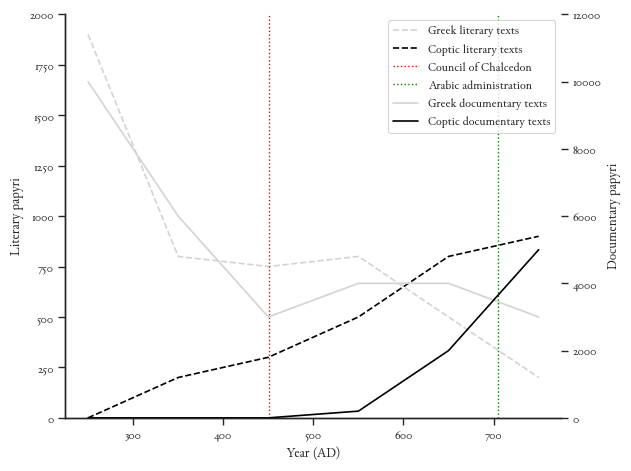

In [123]:
import matplotlib.pyplot as plt

periods = [250, 350, 450, 550, 650, 750]
greek_lit = [1900, 800, 750, 800, 500, 200]
coptic_lit = [0, 200, 300, 500, 800, 900]
greek_doc = [10000, 6000, 3000, 4000, 4000, 3000]
coptic_doc = [0, 0, 0, 200, 2000, 5000]

# Create plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel("Year (AD)")

ax1.plot(periods, greek_lit, linestyle='--', color='lightgray', label='Greek literary texts')
ax1.plot(periods, coptic_lit, linestyle='--', color='black', label='Coptic literary texts')
ax2.plot(periods, greek_doc, linestyle='-', color='lightgray', label='Greek documentary texts')
ax2.plot(periods, coptic_doc, linestyle='-', color='black', label='Coptic documentary texts')
ax1.set_ylabel("Literary papyri")
ax2.set_ylabel("Documentary papyri")
ax1.set_ylim(0, 2000)
ax2.set_ylim(0, 12000)

ax1.axvline(x=451, color='red', linestyle=':', linewidth=1, label="Council of Chalcedon")
ax1.axvline(x=705, color='green', linestyle=':', linewidth=1, label="Arabic administration")

# Combine and show legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.tight_layout()
sns.despine(trim=False)
write_figure("greek_coptic_lit_doc")
plt.show()


# Data overview

In [124]:
df_attestations = pd.read_csv("attestations.csv")

/tmp/nix-shell.VOfIjX/ipykernel_2775623/109604783.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_attestations = pd.read_csv("attestations.csv")


In [125]:
df_diff = pd.read_csv("deviations.csv")

In [126]:
df_diff.dialect.unique()

array(['L5', 'S', 'F', 'V', 'W', 'B', 'A', 'L', 'L6', 'M', 'L4', 'H'],
      dtype=object)

In [127]:
dialect_groups = list("BFMSLA")
dialects = ["B", "F", "V", "M", "W", "S", "H", "L", "L4", "L5", "L6", "A", "P"]

df_diff["dialect_group"] = pd.Categorical(df_diff["dialect_group"], dialect_groups)
df_diff["dialect"] = pd.Categorical(df_diff["dialect"], dialects)

df_attestations["dialect_group"] = pd.Categorical(df_attestations["dialect_group"], dialect_groups)
df_attestations["dialect"] = pd.Categorical(df_attestations["dialect"], dialects)

In [128]:
df_dialects = df_attestations.groupby("dialect_group").agg({
    "manuscript_text": ['nunique'],
    "greek_lemma": ['count', 'nunique'],
    "earliest": ['min'],
    "latest": ['max'],
})
write_csv(df_dialects, "dialects_all")
df_dialects

/tmp/nix-shell.VOfIjX/ipykernel_2775623/1630693263.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dialects = df_attestations.groupby("dialect_group").agg({


manuscript_text greek_lemma         earliest  latest
                      nunique       count nunique      min     max
dialect_group                                                     
B                          39        9181    1109    300.0  1249.0
F                          69        3405     571    200.0  1199.0
M                          19        8421     683    364.0   599.0
S                        2914      160092    4401    200.0  1299.0
L                         130        8358     956    200.0   499.0
A                          26        5589     611    300.0   599.0

In [129]:
df_dialects = df_attestations[~np.isnan(df_attestations.date_approximate)].groupby("dialect_group").agg({
    "manuscript_text": ['nunique'],
    "greek_lemma": ['count', 'nunique'],
    "date_approximate": ['min', 'median', 'max'],
})
write_csv(df_dialects, "dialects_dated")
df_dialects

/tmp/nix-shell.VOfIjX/ipykernel_2775623/2183164698.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_dialects = df_attestations[~np.isnan(df_attestations.date_approximate)].groupby("dialect_group").agg({


manuscript_text greek_lemma         date_approximate         \
                      nunique       count nunique              min median   
dialect_group                                                               
B                          16        3946     748            349.5  699.5   
F                          48        1950     394            299.5  799.5   
M                          10        6743     628            398.5  449.5   
S                        1522       64534    3152            299.5  849.5   
L                         119        4719     695            249.5  349.5   
A                          11        4195     520            349.5  349.5   

                       
                  max  
dialect_group          
B              1212.0  
F              1099.5  
M               549.5  
S              1149.5  
L               404.0  
A               499.5

<Axes: xlabel='material', ylabel='accuracy'>

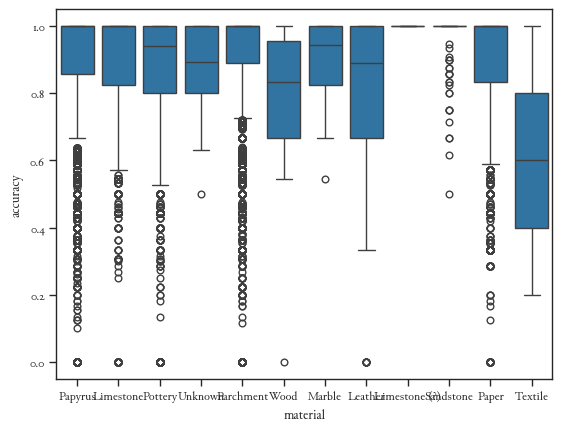

In [130]:
sns.boxplot(df_attestations, y="accuracy", x="material")

<Axes: xlabel='accuracy', ylabel='Count'>

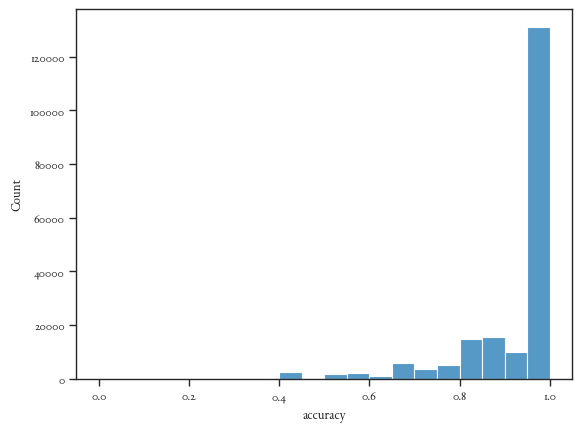

In [138]:
sns.histplot(df_attestations.accuracy, bins=20)

# Is there an influence of era on spelling accuracy?

In [131]:
from difflib import SequenceMatcher
df_attestations["accuracy"] = df_attestations.dropna(subset=["greek_lemma", "orthography_clean"]).apply(lambda row: SequenceMatcher(None, row["greek_lemma"], row["orthography_clean"]).ratio(), axis=1)

In [132]:
df_attestations["era"] = df_attestations["date_approximate"].apply(lambda date: None if math.isnan(date) else "pre-chalcedon" if date < 451 else "post-chalcedon" if date < 705 else "arab")

In [133]:
df_attestations.groupby("era")["accuracy"].agg(["mean", "std"])

,mean,std
era,,
arab,0.907922,0.149258
post-chalcedon,0.913683,0.140172
pre-chalcedon,0.945933,0.110871


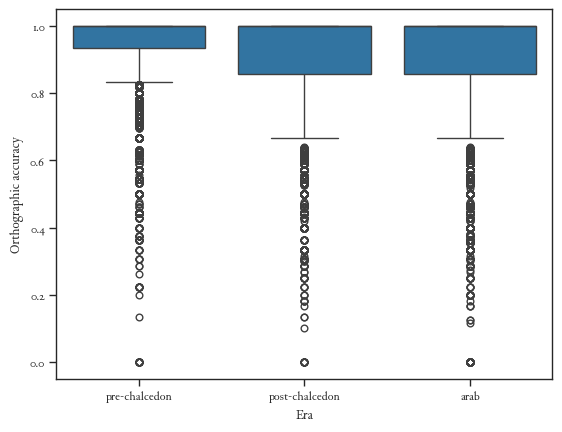

In [134]:
sns.boxplot(df_attestations, y="accuracy", x="era")
#plt.yscale("log")
plt.ylabel("Orthographic accuracy")
plt.xlabel("Era")
#sns.despine(trim=True)
write_figure("accuracy_by_era")

In [135]:
names = ["pre-chalcedon", "post-chalcedon", "arab"]

groups = [
    df_attestations[df_attestations["era"] == name]["accuracy"].values for name in names
]


era_results = u_test(groups, names)
era_results.index = era_results.index.map(lambda x: ' vs. '.join(x))
write_csv(era_results, "era_u")
era_results

,U,p,r,N_1,N_2
pre-chalcedon vs. post-chalcedon,245221210.5,1.744098e-173,0.133044,29678,14585
pre-chalcedon vs. arab,708373437.5,0.000000e+00,0.141385,29678,41824
post-chalcedon vs. arab,308159965.5,3.416647e-02,0.010356,14585,41824


# How does the rate of deviations develop across time?

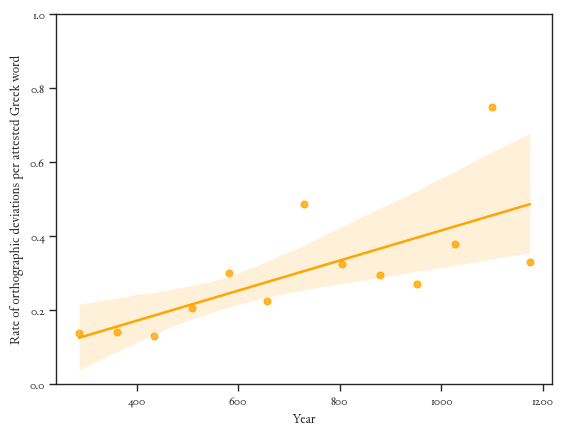

In [148]:
import numpy as np
import matplotlib.pyplot as plt

x1 = df_diff['date_approximate'].dropna()
x2 = df_attestations['date_approximate'].dropna()

bins = np.linspace(min(x1.min(), x2.min()), max(x1.max(), x2.max()), 14)
bin_centers = (bins[:-1] + bins[1:]) / 2

counts1, _ = np.histogram(x1, bins=bins)
counts2, _ = np.histogram(x2, bins=bins)

# Avoid division by zero
counts2_safe = np.where(counts2 == 0, np.nan, counts2)
ratio = counts1 / counts2_safe

sns.regplot(x=bin_centers, y=ratio, color='orange', label='Raw Ratio')
plt.xlabel('Year')
plt.ylabel('Rate of orthographic deviations per attested Greek word')
plt.ylim(0,1)
#sns.despine()

write_figure("attestations_by_deviations")

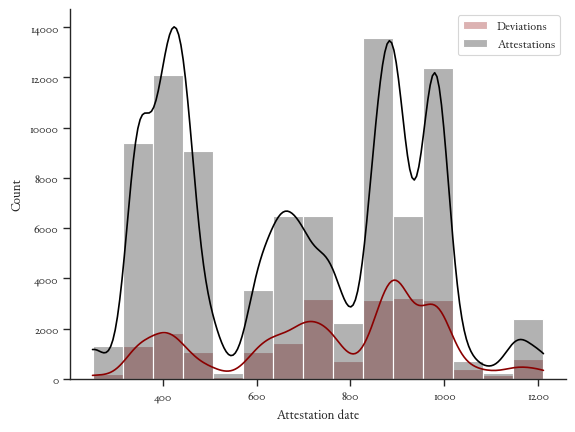

In [19]:
sns.histplot(
    data=df_diff,
    x='date_approximate',
    bins=15,
    kde=True,
    color='darkred',
    label='Deviations',
    alpha=0.3
)

sns.histplot(
    data=df_attestations,
    x='date_approximate',
    bins=15,
    kde=True,
    color='black',
    label='Attestations',
    alpha=0.3
)

# Styling
sns.despine(trim=False)
plt.legend()
plt.xlabel("Attestation date")
plt.ylabel("Count")
write_figure("attestations_deviations")

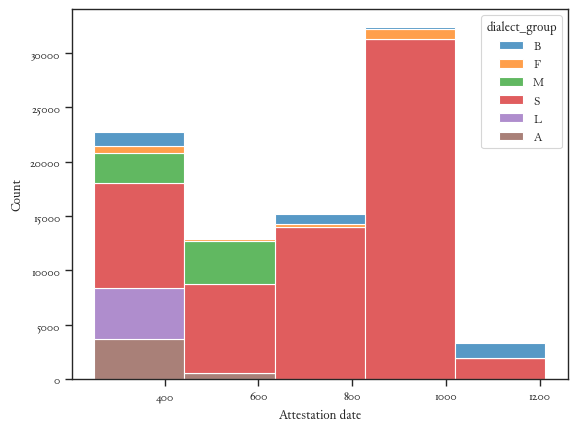

In [20]:
sns.histplot(
    data=df_attestations,
    x='date_approximate',
    bins=5,
    hue="dialect_group",
    multiple="stack"
)


#sns.despine(trim=False)
#plt.legend(True)
plt.xlabel("Attestation date")
plt.ylabel("Count")
write_figure("attestations_dialects")

# How does the rate of deviations behave across dialects?

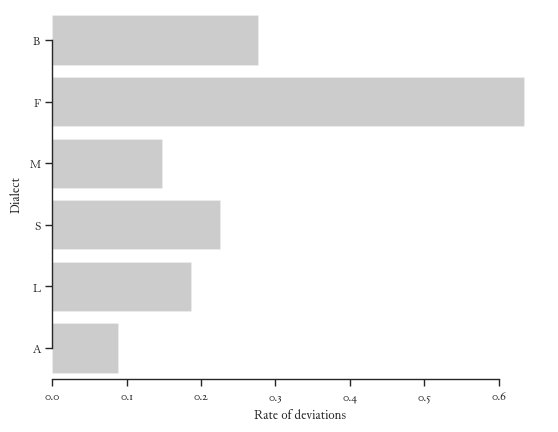

In [21]:
dialect_ratios = df_diff["dialect_group"].value_counts() / df_attestations["dialect_group"].value_counts()
dialect_ratios_df = dialect_ratios.reset_index()
dialect_ratios_df.columns = ["Dialect", "Rate of deviations"]
sns.barplot(dialect_ratios_df, x="Rate of deviations", y="Dialect", color="black", alpha=0.2)
sns.despine(trim=True)
write_figure("deviations_by_dialect")

In [22]:
names = dialect_groups

groups = [
    df_attestations[df_attestations["dialect_group"] == name]["accuracy"].values for name in names
]


dial_results = u_test(groups, names)
dial_results.index = dial_results.index.map(lambda x: ' vs. '.join(x))
write_csv(dial_results, "dialects_u")
dial_results.style.background_gradient(axis="rows", cmap=cm)

,U,p,r,N_1,N_2
B vs. F,18132866.00,0.00,-0.16,9181,3405
B vs. M,37588289.00,0.00,0.03,9181,8421
B vs. S,742533272.50,0.05,-0.01,9181,160092
B vs. L,37132463.00,0.00,0.03,9181,8358
B vs. A,22322509.00,0.00,0.13,9181,5589
F vs. M,11601719.00,0.00,0.19,3405,8421
F vs. S,230552813.50,0.00,0.15,3405,160092
F vs. L,11446215.00,0.00,0.20,3405,8358
F vs. A,6769252.50,0.00,0.29,3405,5589
M vs. S,699921461.00,0.00,-0.04,8421,160092


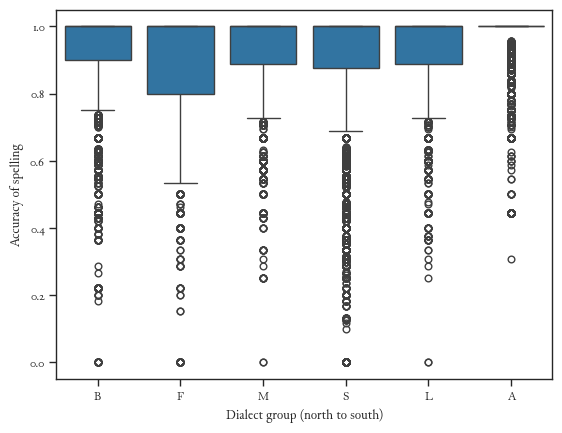

In [23]:
sns.boxplot(df_attestations, y="accuracy", x="dialect_group")
#sns.despine(trim=True)
plt.xlabel("Dialect group (north to south)")
plt.ylabel("Accuracy of spelling")
write_figure("accuracy_by_dialect")

# Grouping deviations

In [24]:
consonants = set("ⲡ ⲧ ⲕ ⲃ ⲇ ⲅ ⲫ ⲑ ⲭ ϩ ⲥ ϣ ϥ ϫ ϭ ⲗ ⲣ ⳉ ϧ ⲛ ⲙ ⲍ ⲝ ⲯ".split())
vowels = set("ⲁ ⲉ ⲏ ⲓ ⲟ ⲱ ⲩ".split())
diphthongs = set("ⲁⲓ ⲉⲓ ⲏⲓ ⲟⲓ ⲩⲓ ⲱⲓ ⲁⲩ ⲉⲩ ⲟⲩ ⲏⲩ".split())

morphological_lapsus = {"∅→ⲥ", "∅→ⲓ", "∅→", "∅→", "∅→ⲏ", "∅→ⲕ", "∅→ⲧ", "∅→ⲡ", "∅→ⲣ", "∅→ⲟⲥ", "∅→ⲟⲩ", "ⲏ→ⲁ"}

deviation_operates_in = lambda graphemes: lambda deviation: deviation["norm"] in graphemes and deviation["var"] in graphemes

def classify(deviation):
    norm, var = deviation["norm"], deviation["var"]
    operates_in = lambda graphemes: deviation_operates_in(graphemes)(deviation)
    if operates_in({"ⲧ", "ⲇ"}) or operates_in({"ⲕ", "ⲅ"}) or operates_in({"ⲃ", "ⲡ"}) or operates_in({"ⲥ", "ⲍ"}):
        return "voiced_voiceless", "nongreek"
    elif operates_in({"ⲗ", "ⲣ"}):
        return "lambdacism", "nongreek"
    elif operates_in({"ⲧ", "ⲑ"}) or operates_in({"ⲫ", "ⲡ"}) or operates_in({"ⲭ", "ⲕ"}):
        return "aspiration", "nongreek"
    elif operates_in({"∅", "ϩ"}):
        return "aspiration", "greek"
    elif operates_in({"ⲁⲓ", "ⲉ"}) or operates_in({"ⲱ", "ⲱⲓ"}) or operates_in({"ⲏⲓ", "ⲏ"}) or operates_in({"ⲏⲓ", "ⲓ"}) or operates_in({"ⲟⲓ", "ⲩ"}):
        return "monophthongization", "greek"
    elif operates_in({"ⲉⲓ", "ⲓ"}):
        return "front_vowel", "greek"
    elif operates_in({"ⲟ", "ⲱ"}):
        return "back_vowel", "greek"
    elif operates_in({"ⲟⲓ", "ⲉ"}) or operates_in({"ⲁⲓ", "ⲁ"}) or operates_in({"ⲩⲓ", "ⲩ"}):
        return "monophthongization", "nongreek"
    elif operates_in({"ⲟ", "ⲱ", "ⲟⲩ", "ⲱⲓ"}) or operates_in({"ⲁ", "ⲟ"}): # ôi ~ ô already attributed to monophthongisation
        return "back_vowel", "nongreek"
    elif operates_in({"ⲏ", "ⲉ", "ⲩ", "ⲉⲓ", "ⲓ", "ⲟⲓ", "ⲁⲓ"}) or operates_in({"ⲁ", "ⲉ"}): # ai/oi ~ e already attributed to monophthongisation
        return "front_vowel", "nongreek"
    elif operates_in({"ⲛ", "∅"}) or operates_in({"ⲙ", "∅"}) or operates_in({"ⲅ", "ⲛ"}):
        return "nasal", "nongreek"
    elif operates_in({"ⲕ", "ϭ"}) or operates_in({"ϩ", "ϣ"}) or operates_in({"ⲭ", "ϫ"}):
        return "palatalisation", "nongreek"
    elif norm == 2 * var or var == 2 * norm:
        return "gemination", "greek"
    elif operates_in({"ⲉ", "∅"}) or operates_in({"ⲓ", "∅"}) or operates_in({"ⲁ", "∅"}) or operates_in({"ⲟ", "∅"}) or operates_in({"ⲩ", "∅"}):
        return "epenthesis", "nongreek"
    elif norm == "ⲟ" and var == "ⲉ":
        return "reduction", "nongreek"
    elif operates_in({"ϥ", "ⲃ"}):
        return "spirantisation", "nongreek"
    else:
        return None, None

df_diff[["shift_class", "shift_origin"]] = df_diff.apply(classify, axis=1, result_type='expand')

### Statistical Prerequisites: Regularity

We define the *regularity* of an orthographic deviation to be its absolute frequency (how often it did appear) divided by the frequency with which the input appears in all Greek lemmata (how often it *could* appear).

Note that the *regularity* of an insertion is undefined. We cannot count the frequency of its input, i.e. the empty string.

# What influences (de-)geminations?

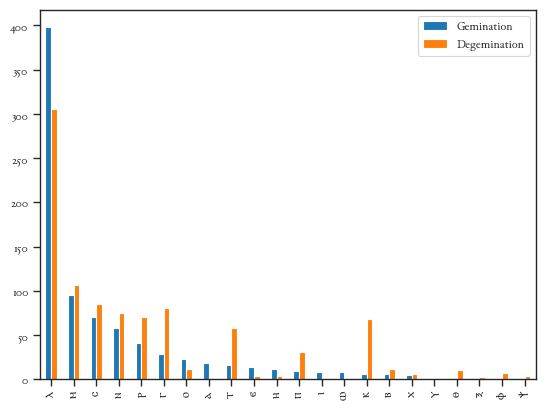

In [25]:
geminations = df_diff[(df_diff["norm"] * 2 == df_diff["var"])]
degeminations = df_diff[(df_diff["norm"] == df_diff["var"] * 2)]

interesting = vowels | consonants

geminate_occurrences = pd.Series({x: df_diff["greek_lemma"].str.count(x * 2).sum() for x in interesting})

gemination_occurrences = geminations[geminations["norm"].isin(interesting)]["norm"].value_counts()
degemination_occurrences = degeminations[degeminations["var"].isin(interesting)]["var"].value_counts()

pd.DataFrame({
    "Gemination": gemination_occurrences,
    "Degemination": degemination_occurrences,
}).sort_values(by="Gemination", ascending=False).plot.bar()
write_figure("gemination_degemination")

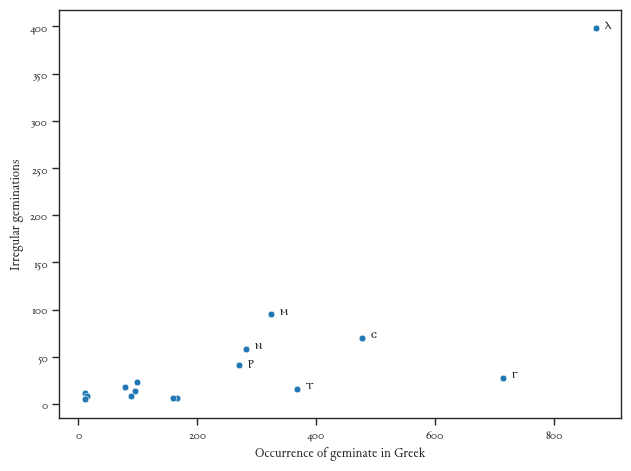

In [26]:
degemination_vs_geminates = pd.DataFrame({
    "Degemination": degemination_occurrences,
    "Geminates": geminate_occurrences,
    "Gemination": gemination_occurrences,
}).dropna()
ax = sns.scatterplot(degemination_vs_geminates, y="Gemination", x="Geminates")
plt.ylabel("Irregular geminations")
plt.tight_layout()
plt.xlabel("Occurrence of geminate in Greek")
for key, x in degemination_vs_geminates.iterrows():
    if any([n>=200 for n in x]):
        ax.text(x=x["Geminates"] + 15, y=x["Gemination"], s=key)
write_figure("geminations_geminates")
#plt.yscale("log")
stat_geminations_geminates = scipy.stats.spearmanr(degemination_vs_geminates["Geminates"], degemination_vs_geminates["Gemination"])
write_json(stat_geminations_geminates, "geminations_geminates")

## Is Bohairic different?

In [27]:
x_gem = geminations[geminations["norm"].isin(interesting)]
x_deg = degeminations[degeminations["var"].isin(interesting)]

x_gem_deg = pd.concat([x_gem, x_deg])

#pd.crosstab(x_gem_deg["deviation"], x_gem_deg["dialect_group"]).sort_values(by="S", ascending=False).style.background_gradient(axis="rows", cmap=cm)
xtab_gem = pd.crosstab(df_diff.shift_class == "gemination", df_diff.dialect_group == "B").rename(
    columns={
        True: 'B',  # Rename True to 'Group B'
        False: 'F/M/S/L/A'    # Rename False to 'Other'
    },
    index={
        True: 'Gemination deviation',  # Rename True to 'Aspiration & Non-Greek'
        False: 'Other deviation'        # Rename False to 'Other Combinations'
    }
)

stats_gem = contingency_statistics(xtab_gem)

write_json(stats_gem, "dialect_gemination")
write_csv(xtab_gem, "dialect_gemination")

print(stats_gem)
xtab_gem

{'chi^2': 0.058748054076303576, 'p': 0.8084857466052262, 'df': 1, 'V': 0.0013956622830883449}


dialect_group,F/M/S/L/A,B
shift_class,,
Other deviation,40115,2439
Gemination deviation,1713,101


# Vowel alternations

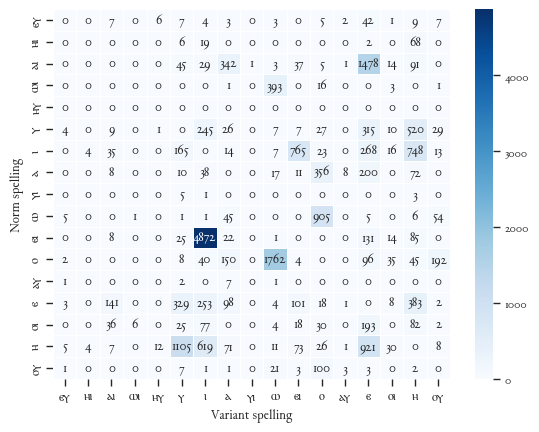

In [179]:
df_diff_vocalic = df_diff[df_diff["norm"].isin(vowels | diphthongs) & df_diff["var"].isin(vowels | diphthongs)]
vowel_frequency_data = pd.crosstab(df_diff_vocalic["norm"], df_diff_vocalic["var"])

unique_labels = list(set(vowel_frequency_data.index).union(set(vowel_frequency_data.columns)))

vowel_frequency = pd.DataFrame(0, index=unique_labels, columns=unique_labels)

vowel_frequency.update(vowel_frequency_data)

write_csv(vowel_frequency, "vowel_frequency")
sns.heatmap(vowel_frequency, cmap=cm, annot=True, linewidth=0.5, fmt="d")
plt.xlabel("Variant spelling")
plt.ylabel("Norm spelling")
write_figure("vowel_frequency")

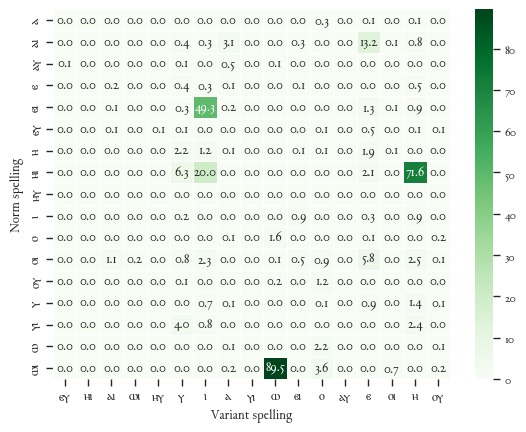

In [180]:
vowel_occurrences = pd.Series({x: df_attestations["greek_lemma"].str.count(x).sum() for x in vowels | diphthongs})

vowel_regularity = 100 * vowel_frequency.div(vowel_occurrences, axis="rows").fillna(0)
write_csv(vowel_regularity, "vowel_regularity")
sns.heatmap(vowel_regularity, annot=True, fmt=".1f", linewidth=0.5, cmap="Greens")
plt.xlabel("Variant spelling")
plt.ylabel("Norm spelling")
write_figure("vowel_regularity")

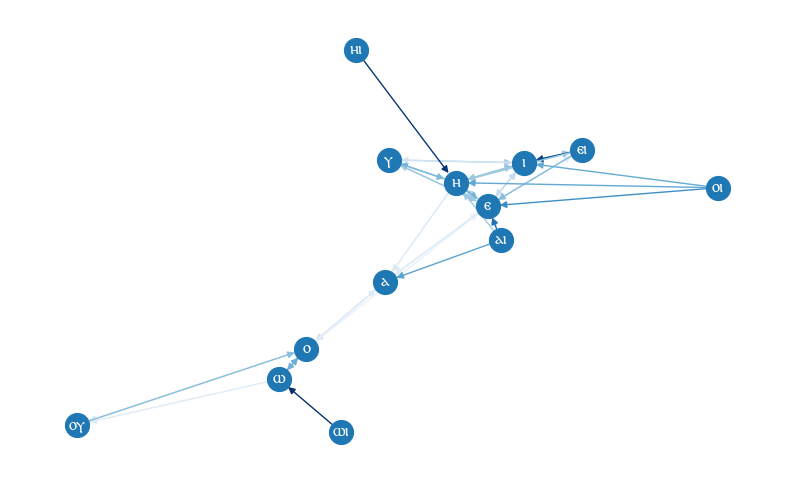

In [30]:
all_vowel_regularities = vowel_regularity.stack().reset_index().rename(columns={"level_0": "norm", "level_1": "var", 0: "regularity"})
all_vowel_frequencies = vowel_frequency.stack().reset_index().rename(columns={"level_0": "norm", "level_1": "var", 0: "frequency"})
vowel_deviations = pd.merge(all_vowel_regularities, all_vowel_frequencies, on=["norm", "var"])

fig = plt.figure(figsize=(10, 6))

graph = nx.from_pandas_edgelist(
    vowel_deviations[vowel_deviations["frequency"] >= 50],
    source="norm",
    target="var",
    edge_attr=["regularity", "frequency"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, weight="frequency", seed=6)

nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(v) for v in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)

fig.savefig(subdirectory / "figure-vowels_graph.svg")
plt.show()

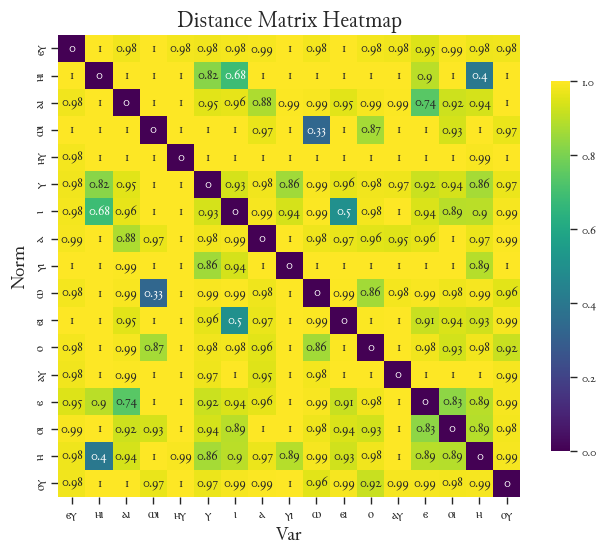

/tmp/nix-shell.VOfIjX/ipykernel_2775623/56228725.py:35: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


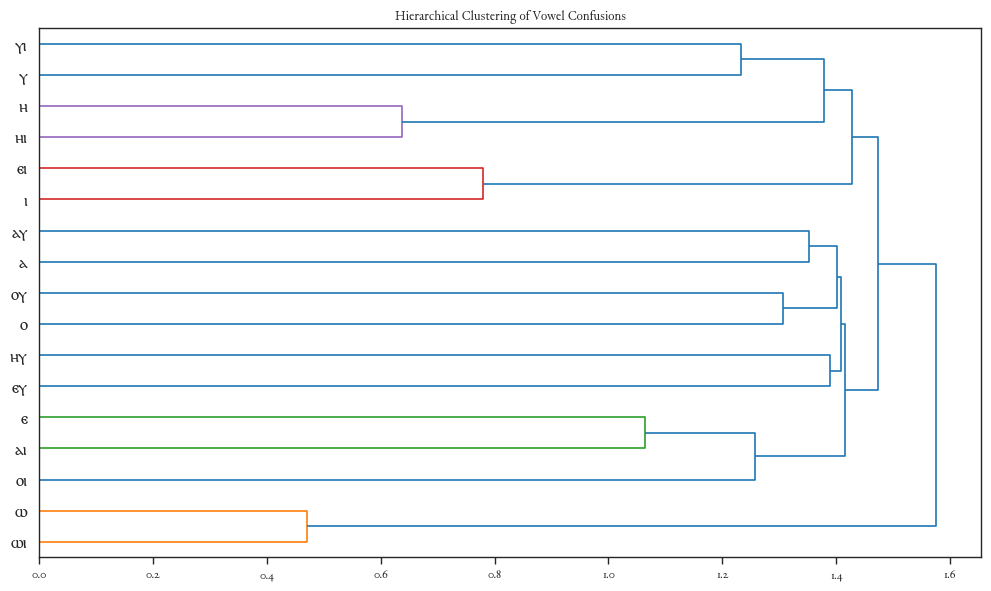

In [31]:
# Make a copy to avoid modifying original
norm_confusion = vowel_frequency.copy().astype(float)

# Normalize each row by its total occurrence count
for grapheme in norm_confusion.index:
    if grapheme in vowel_occurrences:
        total = vowel_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)

# Fill the diagonal with 0
np.fill_diagonal(distance_matrix, 0)

# Option 1: Update the DataFrame directly
distance_df.iloc[:, :] = distance_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Add titles and labels
plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)

# Show the plot
plt.show()

from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Vowel Confusions")
plt.tight_layout()
plt.show()


In [32]:
front_vowel_list = ["ⲩ", "ⲟⲓ", "ⲓ", "ⲏ", "ⲁⲓ", "ⲉ", "ⲟ", "ⲱ", "ⲁ"]
front_vowels = df_diff[df_diff["norm"].isin(front_vowel_list)].copy()
front_vowels["realization"] = front_vowels["var"].apply(lambda x: "ⲓ, ⲩ, ⲉⲓ, ⲟⲓ /i, y/" if x in {"ⲟⲓ", "ⲩ", "ⲓ", "ⲉⲓ"} else "ⲉ, ⲏ, ⲁⲓ /e, ɛ/" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "ⲟ, ⲱ, ⲟⲩ /ɔ, o, u/" if x in {"ⲟⲩ", "ⲟ", "ⲱ"} else "ⲁ /a/" if x in {"ⲁ"} else None)

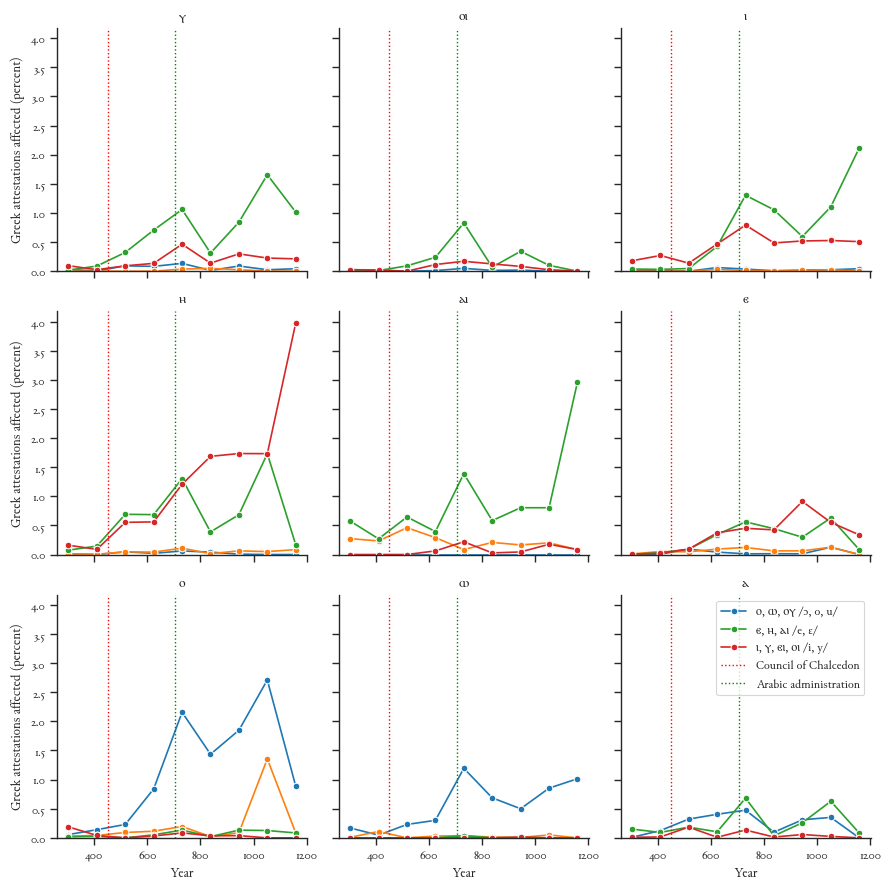

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

full_dates = df_attestations['date_approximate'].dropna()
bins = np.linspace(full_dates.min(), full_dates.max(), 10)
bin_centers = (bins[:-1] + bins[1:]) / 2
full_counts, _ = np.histogram(full_dates, bins=bins)
full_counts_safe = np.where(full_counts == 0, 1e-8, full_counts)

plot_data = []

# Iterate over each combination of norm and realization
for norm_value in front_vowels["norm"].unique():
    norm_subset = front_vowels[front_vowels["norm"] == norm_value]

    for realization_value in norm_subset["realization"].dropna().unique():
        subset = norm_subset[norm_subset["realization"] == realization_value]
        dates = subset['date_approximate'].dropna()

        # Histogram
        counts, _ = np.histogram(dates, bins=bins)
        ratio = counts / full_counts_safe
        # Collect results
        for x, y in zip(bin_centers, ratio):
            plot_data.append({
                'year': x,
                'ratio': y * 100,
                'norm': norm_value,
                'realization': realization_value
            })

plot_df = pd.DataFrame(plot_data)

g = sns.FacetGrid(plot_df, col="norm", hue="realization", col_wrap=3, sharey=True, col_order=front_vowel_list)
g.map_dataframe(sns.lineplot, x="year", y="ratio", marker='o')
g.set(ylim=0)
g.set_axis_labels("Year", "Greek attestations affected (percent)")
g.set_titles(col_template="{col_name}")
#g.add_legend()

for ax in g.axes.flat:
    ax.axvline(x=451, color='red', linestyle=':', linewidth=1, label="Council of Chalcedon")
    ax.axvline(x=705, color='green', linestyle=':', linewidth=1, label="Arabic administration")



plt.tight_layout()
plt.legend()
plt.show()
g.savefig(subdirectory / "figure-front_vowels_by_year.svg")

## Diphthongs

<Axes: xlabel='date_approximate', ylabel='Count'>

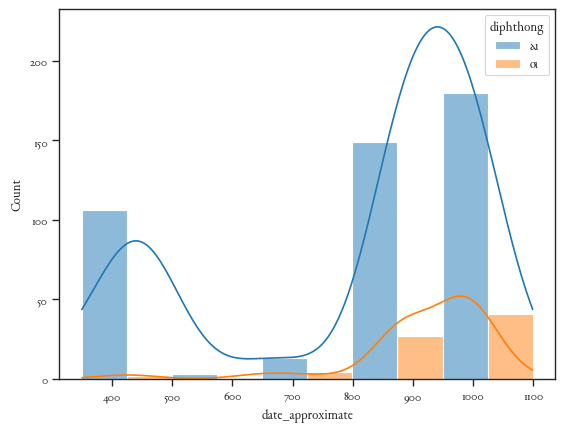

In [34]:
spelling_pronunciation = df_attestations[
    (df_attestations["greek_lemma"].str.contains("ⲟⲓ") & df_attestations["orthography"].str.contains("ⲟⲓ̈"))
    | (df_attestations["greek_lemma"].str.contains("ⲁⲓ") & df_attestations["orthography"].str.contains("ⲁⲓ̈"))
].copy()
spelling_pronunciation["diphthong"] = spelling_pronunciation["orthography"].apply(lambda x: "ⲟⲓ" if "ⲟⲓ̈" in x else "ⲁⲓ" if "ⲁⲓ̈" in x else "?")
sns.histplot(data=spelling_pronunciation, x='date_approximate', multiple="dodge", hue='diphthong', bins=5, kde=True)

<https://kmein.github.io/greek-coptic-dashboard/?orthography_regex=%E2%B2%81%E2%B2%93%CC%88|%E2%B2%9F%E2%B2%93%CC%88&greek_lemma_regex=%E2%B2%81%E2%B2%93|%E2%B2%9F%E2%B2%93>

In [35]:
spelling_pronunciation.sample(10)["orthography"]

78981         ⲓ̈ⲟⲩⲇⲁⲓ̈
120181       ⲓ̈ⲟⲩ|ⲇⲁⲓ̈
157941         ⲗⲟⲓ̈ⲡⲟⲛ
157949         ⲗⲟⲓ̈ⲡⲟⲛ
120234    ⲇⲓ̈ⲕⲁⲓ̈ⲟⲥⲩⲛⲏ
157809         ⲗⲟⲓ̈ⲡⲟⲛ
85355         ⲓ̈ⲟⲩⲇⲁⲓ̈
157290      ⲟⲓ̈ⲕⲟⲛⲟⲙⲟⲥ
143210       ⲥⲡⲩⲗⲁⲓ̈ⲟⲛ
179403       ⲕⲩⲡⲧⲁⲓ̈ⲟⲛ
Name: orthography, dtype: object

## Progressive spelling of ⲁⲓ/ⲉⲓ in Bohairic?

In [36]:
def categorize(row):
    if row['norm'] == "ⲁⲓ" and row['var'] == "ⲉ":
        return "ⲁⲓ → ⲉ"
    elif row['norm'] == "ⲉⲓ" and row['var'] == "ⲓ":
        return "ⲉⲓ → ⲓ"
    else:
        return "other"
        
xtab_ai_ei = pd.crosstab(
    df_diff.apply(categorize, axis=1),
    df_diff['dialect_group'].isin({"B"})
).rename(
    columns={False: "F/M/S/L/A", True: "B"}
)

stats_ai_ei = contingency_statistics(xtab_ai_ei)


write_csv(xtab_ai_ei, "progressive_ai_ei")
write_json(stats_ai_ei, "progressive_ai_ei")

print(stats_ai_ei)
xtab_ai_ei

{'chi^2': 864.6294252521918, 'p': 1.77054048155522e-188, 'df': 2, 'V': 0.1395982839410524}


dialect_group,F/M/S/L/A,B
row_0,,
other,36144,1874
ⲁⲓ → ⲉ,1139,339
ⲉⲓ → ⲓ,4545,327


In [37]:
xtab_ai_ei_deluxe = chi2_deluxe(xtab_ai_ei)
write_csv(xtab_ai_ei_deluxe, "progressive_ai_ei_contributions")
xtab_ai_ei_deluxe

dialect_group,F/M/S/L/A,B
row_0,,
other,"+, χ² = 2.55 n. s.","–, χ² = 42.04 ***"
ⲁⲓ → ⲉ,"–, χ² = 46.44 ***","+, χ² = 764.81 ***"
ⲉⲓ → ⲓ,"–, χ² = 0.50 n. s.","+, χ² = 8.29 *"


## What influences ⲁ-vowel deviation?

In [38]:
def categorize(row):
    if row['norm'] in {"ⲁ", "ⲟ"} and row['var'] in {"ⲁ", "ⲟ"}:
        return "ⲁ/ⲟ"
    elif row['norm'] == "ⲉ" and row['var'] in {"ⲁ", "ⲉ"}:
        return "ⲉ/ⲁ"
    else:
        return "other"
        
xtab_vocalism = pd.crosstab(
    df_diff.apply(categorize, axis=1),
    df_diff['dialect_group'].isin({"F", "L", "A"})
).rename(
    columns={False: "S/B", True: "F/M/L/A"}
)

stats_vocalism = contingency_statistics(xtab_vocalism)


write_csv(xtab_vocalism, "progressive_vocalism")
write_json(stats_vocalism, "progressive_vocalism")

print(stats_vocalism)
xtab_vocalism

{'chi^2': 29.058559553529182, 'p': 4.897945709221946e-07, 'df': 2, 'V': 0.025591875542752534}


dialect_group,S/B,F/M/L/A
row_0,,
other,39538,4226
ⲁ/ⲟ,493,13
ⲉ/ⲁ,88,10


In [39]:
xtab_vocalism_deluxe = chi2_deluxe(xtab_vocalism)
write_csv(xtab_vocalism_deluxe, "progressive_vocalism_contributions")
xtab_vocalism_deluxe

dialect_group,S/B,F/M/L/A
row_0,,
other,"–, χ² = 0.03 n. s.","+, χ² = 0.29 n. s."
ⲁ/ⲟ,"+, χ² = 2.75 n. s.","–, χ² = 25.95 ***"
ⲉ/ⲁ,"–, χ² = 0.00 n. s.","+, χ² = 0.04 n. s."


## Coarticulation

In [40]:
def place_of_articulation(x):
    if x in {"ⲃ", "ⲡ", "ⲫ", "ⲙ", "ⲯ"}:
        return "labial"
    elif x in {"ⲅ", "ⲕ", "ⲭ", "ⲝ"}:
        return "velar"
    elif x in {"ⲇ", "ⲧ", "ⲑ", "ⲗ", "ⲛ", "ⲣ", "ⲥ", "ⲍ"}:
        return "alveolar"
    else:
        return None


def compare_vowels(vowel1, vowel2, strata):
    # Create a mapping of vowels to their stratum index
    stratum_index = {vowel: index for index, stratum in enumerate(strata) for vowel in stratum}
    
    # Get the indices of the vowels
    index1 = stratum_index.get(vowel1)
    index2 = stratum_index.get(vowel2)
    
    # Compare the indices
    if index1 is None or index2 is None:
        return None  # Return None if one or both vowels are not found
    elif index1 < index2:
        return -1  # vowel1 is in an earlier stratum
    elif index1 > index2:
        return +1  # vowel1 is in a later stratum
    else:
        return 0  # Both vowels are in the same stratum

# assuming early koine inventory
vowel_height = [["ⲓ", "ⲉⲓ", "ⲟⲩ", "ⲏ", "ⲟⲓ", "ⲩ"], ["ⲁⲓ", "ⲉ", "ⲟ", "ⲱ"], ["ⲁ"]]
vowel_frontness = [["ⲓ", "ⲉⲓ", "ⲩ", "ⲟⲓ", "ⲏ"], ["ⲁⲓ", "ⲉ"], ["ⲁ"], ["ⲟ", "ⲱ"], ["ⲟⲩ"]]
vowel_roundness = [["ⲓ", "ⲉⲓ", "ⲏ", "ⲁⲓ", "ⲉ", "ⲁ"], ["ⲩ", "ⲟⲓ", "ⲟ", "ⲟⲩ", "ⲱ"]]

def process_height(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_height)
    if comparison is not None:
        if comparison < 0:
            return "lowering"
        elif comparison > 0:
            return "raising"
        else:
            #print(comparison, row["norm"], row["var"])
            return "none"

def process_frontness(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_frontness)
    if comparison is not None:
        if comparison < 0:
            return "backing"
        elif comparison > 0:
            return "fronting"
        else:
            return "none"

def process_roundness(row):
    comparison = compare_vowels(row["norm"], row["var"], vowel_roundness)
    if comparison is not None:
        if comparison < 0:
            return "unrounding"
        elif comparison > 0:
            return "rounding"
        else:
            return "none"

x = df_diff[(df_diff["norm"].isin(vowels|diphthongs)) & df_diff["var"].isin(vowels | diphthongs) & (df_diff["context_right"] != "#")].copy()
x["environment_left"] = x.apply(lambda row: place_of_articulation(row.context_left[-1]), axis=1)
x["environment_right"] = x.apply(lambda row: place_of_articulation(row.context_right[0]), axis=1)
x["environment"] = x["environment_left"] + "…" + x["environment_right"]


In [41]:
x["coarticulation_height"] = x.apply(process_height, axis=1).astype('category').cat.reorder_categories(['none', 'lowering', 'raising'], ordered=False)
x["coarticulation_frontness"] = x.apply(process_frontness, axis=1).astype('category').cat.reorder_categories(['none', 'backing', 'fronting'], ordered=False)
x["coarticulation_roundness"] = x.apply(process_roundness, axis=1)
x["velar_adjacent"] = (x["environment_right"] == "velar") | (x["environment_left"] == "velar")
x["alveolar_adjacent"] = (x["environment_right"] == "alveolar") | (x["environment_left"] == "alveolar")
x["labial_adjacent"] = (x["environment_right"] == "labial") | (x["environment_left"] == "labial")
x

,id,norm,var,context_left,context_right,greek_lemma,greek_lemma_original,orthography,orthography_clean,dialect,...,shift_origin,environment_left,environment_right,environment,coarticulation_height,coarticulation_frontness,coarticulation_roundness,velar_adjacent,alveolar_adjacent,labial_adjacent
5,71678,ⲉⲓ,ⲓ,ⲭⲣ,ⲁ,ⲭⲣⲉⲓⲁ,χρεία,ⲭⲣⲓⲁ,ⲭⲣⲓⲁ,L5,...,greek,alveolar,None,NaN,none,none,none,False,True,False
23,72537,ⲉⲓ,ⲓ,ⲡ,ⲣⲁⲍⲱ,ⲡⲉⲓⲣⲁⲍⲱ,πειράζω,ⲡⲓⲣⲁⲍⲉ,ⲡⲓⲣⲁⲍⲉ,L5,...,greek,labial,alveolar,labial…alveolar,none,none,none,False,True,True
39,73321,ⲉⲓ,ⲓ,ⲡⲟⲣⲛ,ⲁ,ⲡⲟⲣⲛⲉⲓⲁ,πορνεία,ⲡ[οⲣ]ⲛⲓⲁ,ⲡⲟⲣⲛⲓⲁ,L5,...,greek,alveolar,None,NaN,none,none,none,False,True,False
54,73457,ⲟⲓ,ⲩ,ⲡⲁⲣ,ⲙⲓⲁ,ⲡⲁⲣⲟⲓⲙⲓⲁ,παροιμία,ⲡⲁⲣϩⲩⲙⲓⲁ,ⲡⲁⲣϩⲩⲙⲓⲁ,L5,...,greek,alveolar,labial,alveolar…labial,none,none,none,False,True,True
78,73720,ⲉⲓ,ⲓ,ⲇ,ⲡⲛⲟⲛ,ⲇⲉⲓⲡⲛⲟⲛ,δεῖπνον,ⲇⲓ[ⲡⲛⲟⲛ],ⲇⲓⲡⲛⲟⲛ,L5,...,greek,alveolar,labial,alveolar…labial,none,none,none,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44349,201043,ⲁ,ⲟ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣ,ⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲁⲥ,μανδραγόρας,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,S,...,nongreek,alveolar,alveolar,alveolar…alveolar,raising,backing,unrounding,False,True,False
44350,201044,ⲁ,ⲟ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣ,ⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲁⲥ,μανδραγόρας,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,S,...,nongreek,alveolar,alveolar,alveolar…alveolar,raising,backing,unrounding,False,True,False
44351,201045,ⲁ,ⲟ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣ,ⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲁⲥ,μανδραγόρας,[ⲙ]ⲁⲛⲇⲣⲁⲅⲟⲣ[ⲟⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,S,...,nongreek,alveolar,alveolar,alveolar…alveolar,raising,backing,unrounding,False,True,False
44352,201046,ⲁ,ⲟ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣ,ⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲁⲥ,μανδραγόρας,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,ⲙⲁⲛⲇⲣⲁⲅⲟⲣⲟⲥ,S,...,nongreek,alveolar,alveolar,alveolar…alveolar,raising,backing,unrounding,False,True,False


### Raising / Lowering

In [42]:
xtab_rhotic_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲣ"})) | (x["context_right"].str[0].isin({"ⲣ"})), x.apply(process_height, axis=1)).rename(
    index={True: "rhotic environment", False: "non-rhotic environment"}
)
print(contingency_statistics(xtab_rhotic_coarticulation))
xtab_rhotic_coarticulation

{'chi^2': 68.60647985738782, 'p': 1.2655875316050132e-15, 'df': 2, 'V': 0.06155953034648383}


col_0,lowering,none,raising
row_0,,,
non-rhotic environment,1861,10504,1529
rhotic environment,691,2916,603


In [43]:
chi2_deluxe(xtab_rhotic_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-rhotic environment,"–, χ² = 4.86 n. s.","+, χ² = 4.07 n. s.","–, χ² = 7.03 *"
rhotic environment,"+, χ² = 16.03 ***","–, χ² = 13.43 **","+, χ² = 23.18 ***"


In [44]:
xtab_nasal_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲙ", "ⲛ"})), x.apply(process_height, axis=1)).rename(
    index={True: "after nasal", False: "after non-nasal"}
)
print(contingency_statistics(xtab_nasal_coarticulation))
xtab_nasal_coarticulation

{'chi^2': 275.4132345296325, 'p': 1.5659431822565783e-60, 'df': 2, 'V': 0.123340337478885}


col_0,lowering,none,raising
context_left,,,
after non-nasal,2035,11926,1676
after nasal,517,1494,456


In [45]:
chi2_deluxe(xtab_nasal_coarticulation)

col_0,lowering,none,raising
context_left,,,
after non-nasal,"–, χ² = 12.99 **","+, χ² = 9.67 *","–, χ² = 14.87 ***"
after nasal,"+, χ² = 82.37 ***","–, χ² = 61.27 ***","+, χ² = 94.25 ***"


In [46]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_height, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'chi^2': 116.60384668293214, 'p': 4.7840576940999593e-26, 'df': 2, 'V': 0.08025445842954732}


col_0,lowering,none,raising
row_0,,,
non-velar environment,2045,9962,1413
velar environment,507,3458,719


In [47]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-velar environment,"+, χ² = 12.42 **","+, χ² = 0.02 n. s.","–, χ² = 17.73 ***"
velar environment,"–, χ² = 35.58 ***","–, χ² = 0.06 n. s.","+, χ² = 50.80 ***"


In [48]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_height, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'chi^2': 100.94218223832837, 'p': 1.204158432524131e-22, 'df': 2, 'V': 0.07467050254562266}


col_0,lowering,none,raising
row_0,,,
non-labial environment,1453,9012,1363
labial environment,1099,4408,769


In [49]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-labial environment,"–, χ² = 27.55 ***","+, χ² = 6.80 n. s.","–, χ² = 0.64 n. s."
labial environment,"+, χ² = 51.92 ***","–, χ² = 12.82 **","+, χ² = 1.21 n. s."


In [50]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_height, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'chi^2': 219.3274901360833, 'p': 2.3639628763397313e-48, 'df': 2, 'V': 0.11006754096271754}


col_0,lowering,none,raising
row_0,,,
non-alveolar environment,341,2674,169
alveolar environment,2211,10746,1963


In [51]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,lowering,none,raising
row_0,,,
non-alveolar environment,"–, χ² = 25.90 ***","+, χ² = 41.72 ***","–, χ² = 113.13 ***"
alveolar environment,"+, χ² = 5.53 n. s.","–, χ² = 8.90 *","+, χ² = 24.14 ***"


### Fronting / Backing

In [52]:
xtab_rhotic_coarticulation = pd.crosstab((x["context_left"].str[-1].isin({"ⲣ"})) | (x["context_right"].str[0].isin({"ⲣ"})), x.apply(process_frontness, axis=1)).rename(
    index={True: "rhotic environment", False: "non-rhotic environment"}
)
print(contingency_statistics(xtab_rhotic_coarticulation))
xtab_rhotic_coarticulation

{'chi^2': 73.25098430119847, 'p': 1.2409402238137253e-16, 'df': 2, 'V': 0.06360913092271563}


col_0,backing,fronting,none
row_0,,,
non-rhotic environment,2052,1489,10353
rhotic environment,839,492,2879


In [53]:
chi2_deluxe(xtab_rhotic_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-rhotic environment,"–, χ² = 12.53 **","–, χ² = 0.65 n. s.","+, χ² = 3.86 n. s."
rhotic environment,"+, χ² = 41.34 ***","+, χ² = 2.13 n. s.","–, χ² = 12.75 **"


In [54]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_frontness, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'chi^2': 29.09706146156228, 'p': 4.804557373000619e-07, 'df': 2, 'V': 0.040090114371286366}


col_0,backing,fronting,none
row_0,,,
non-velar environment,2211,1380,9829
velar environment,680,601,3403


In [55]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-velar environment,"+, χ² = 2.16 n. s.","–, χ² = 5.33 n. s.","+, χ² = 0.04 n. s."
velar environment,"–, χ² = 6.18 n. s.","+, χ² = 15.27 ***","–, χ² = 0.12 n. s."


In [56]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_frontness, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'chi^2': 127.01483294022509, 'p': 2.624698766187987e-28, 'df': 2, 'V': 0.08376063289168917}


col_0,backing,fronting,none
row_0,,,
non-labial environment,1635,1265,8928
labial environment,1256,716,4304


In [57]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-labial environment,"–, χ² = 34.10 ***","–, χ² = 0.66 n. s.","+, χ² = 9.27 *"
labial environment,"+, χ² = 64.27 ***","+, χ² = 1.25 n. s.","–, χ² = 17.47 ***"


In [58]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_frontness, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'chi^2': 165.76399893887893, 'p': 1.0111253093943911e-36, 'df': 2, 'V': 0.09568807926841566}


col_0,backing,fronting,none
row_0,,,
non-alveolar environment,359,208,2617
alveolar environment,2532,1773,10615


In [59]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,backing,fronting,none
row_0,,,
non-alveolar environment,"–, χ² = 43.93 ***","–, χ² = 56.58 ***","+, χ² = 36.10 ***"
alveolar environment,"+, χ² = 9.37 *","+, χ² = 12.07 **","–, χ² = 7.70 *"


### Rounding / unrounding

In [60]:
xtab_velar_coarticulation = pd.crosstab((x["environment_left"] == "velar") | (x["environment_right"] == "velar"), x.apply(process_roundness, axis=1)).rename(
    index={True: "velar environment", False: "non-velar environment"}
)
print(contingency_statistics(xtab_velar_coarticulation))
xtab_velar_coarticulation

{'chi^2': 218.7336644441391, 'p': 3.181180141560343e-48, 'df': 2, 'V': 0.10991843691163236}


col_0,none,rounding,unrounding
row_0,,,
non-velar environment,10691,1384,1345
velar environment,3304,545,835


In [61]:
chi2_deluxe(xtab_velar_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-velar environment,"+, χ² = 9.68 *","–, χ² = 1.47 n. s.","–, χ² = 45.44 ***"
velar environment,"–, χ² = 27.73 ***","+, χ² = 4.22 n. s.","+, χ² = 130.18 ***"


In [62]:
xtab_labial_coarticulation = pd.crosstab((x["environment_left"] == "labial") | (x["environment_right"] == "labial"), x.apply(process_roundness, axis=1)).rename(
    index={True: "labial environment", False: "non-labial environment"}
)
print(contingency_statistics(xtab_labial_coarticulation))
xtab_labial_coarticulation

{'chi^2': 182.53195152245877, 'p': 2.310416840142042e-40, 'df': 2, 'V': 0.10041120479679475}


col_0,none,rounding,unrounding
row_0,,,
non-labial environment,9501,1059,1268
labial environment,4494,870,912


In [63]:
chi2_deluxe(xtab_labial_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-labial environment,"+, χ² = 13.98 **","–, χ² = 32.15 ***","–, χ² = 17.15 ***"
labial environment,"–, χ² = 26.35 ***","+, χ² = 60.59 ***","+, χ² = 32.31 ***"


In [64]:
xtab_alveolar_coarticulation = pd.crosstab((x["environment_left"] == "alveolar") | (x["environment_right"] == "alveolar"), x.apply(process_roundness, axis=1)).rename(
    index={True: "alveolar environment", False: "non-alveolar environment"}
)
print(contingency_statistics(xtab_alveolar_coarticulation))
xtab_alveolar_coarticulation

{'chi^2': 50.48671784771151, 'p': 1.0888010090171554e-11, 'df': 2, 'V': 0.05280819197455745}


col_0,none,rounding,unrounding
row_0,,,
non-alveolar environment,2533,382,269
alveolar environment,11462,1547,1911


In [65]:
chi2_deluxe(xtab_alveolar_coarticulation)

col_0,none,rounding,unrounding
row_0,,,
non-alveolar environment,"+, χ² = 2.09 n. s.","+, χ² = 5.38 n. s.","–, χ² = 34.14 ***"
alveolar environment,"–, χ² = 0.45 n. s.","–, χ² = 1.15 n. s.","+, χ² = 7.28 *"


# Consonant alternations

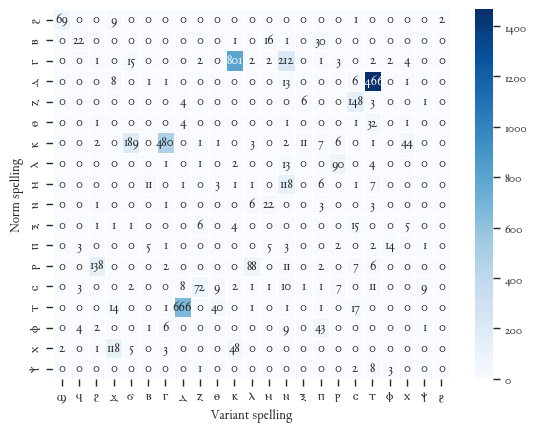

In [178]:
df_diff_consonantal = df_diff[df_diff["norm"].isin(consonants) & df_diff["var"].isin(consonants)]
consonant_frequency = pd.crosstab(df_diff_consonantal["norm"], df_diff_consonantal["var"])
consonant_frequency = consonant_frequency.loc[consonant_frequency.any(axis=1), consonant_frequency.any(axis=0)]
write_csv(consonant_frequency, "consonant_frequency")
sns.heatmap(consonant_frequency, cmap=cm, annot=True, linewidth=0.5, fmt="d")
plt.xlabel("Variant spelling")
plt.ylabel("Norm spelling")
write_figure("consonant_frequency")

In [67]:
pd.DataFrame(df_diff_consonantal.groupby(["norm", "var"])["date_approximate"].agg("median").unstack()).style.background_gradient(axis=None, cmap=cm)

var,ϣ,ϥ,ϩ,ϫ,ϭ,ⲃ,ⲅ,ⲇ,ⲍ,ⲑ,ⲕ,ⲗ,ⲙ,ⲛ,ⲝ,ⲡ,ⲣ,ⲥ,ⲧ,ⲫ,ⲭ,ⲯ,ⳉ
norm,,,,,,,,,,,,,,,,,,,,,,,
ϩ,–,–,–,349.50,–,–,–,–,–,–,–,–,–,–,–,–,–,899.50,–,–,–,–,889.50
ⲃ,–,819.50,–,–,–,–,–,–,–,–,–,–,349.50,–,–,699.50,–,–,–,–,–,–,–
ⲅ,–,–,–,–,624.50,–,–,–,404.00,–,887.00,–,949.50,862.00,–,637.00,749.50,–,999.50,699.50,1012.00,–,–
ⲇ,–,–,–,499.50,–,887.00,–,–,–,–,–,–,–,449.50,–,–,–,349.50,749.50,–,899.50,–,–
ⲍ,–,–,–,–,–,–,–,1024.50,–,–,–,–,–,–,862.00,–,–,799.50,862.00,–,–,–,–
ⲑ,–,–,899.50,–,–,–,–,982.00,–,–,–,–,–,–,–,–,–,–,649.50,–,912.00,–,–
ⲕ,–,–,649.50,–,449.50,–,899.50,–,349.50,899.50,–,–,–,–,649.50,749.50,349.50,–,1174.50,–,874.50,–,–
ⲗ,–,–,–,–,–,–,974.50,–,1174.50,–,849.50,–,–,974.50,–,–,899.50,–,887.00,–,–,–,–
ⲙ,–,–,–,–,–,849.50,–,649.50,–,724.50,862.00,–,–,887.00,–,412.00,–,899.50,643.25,–,–,–,–


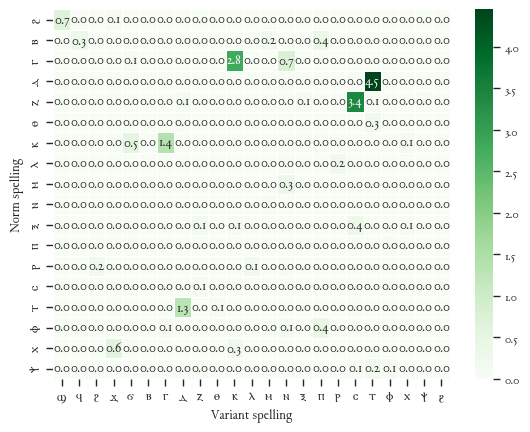

In [177]:
consonant_occurrences = pd.Series({x: df_attestations["greek_lemma"].str.count(x).sum() for x in consonants})

consonant_regularity = consonant_frequency.div(consonant_occurrences, axis="rows").fillna(0)
consonant_regularity = 100 * consonant_regularity.loc[consonant_regularity.any(axis=1), consonant_regularity.any(axis=0)]
write_csv(consonant_regularity, "consonant_regularity")
sns.heatmap(consonant_regularity, cmap="Greens", annot=True, linewidth=0.5, fmt=".1f")
plt.xlabel("Variant spelling")
plt.ylabel("Norm spelling")
write_figure("consonant_regularity")

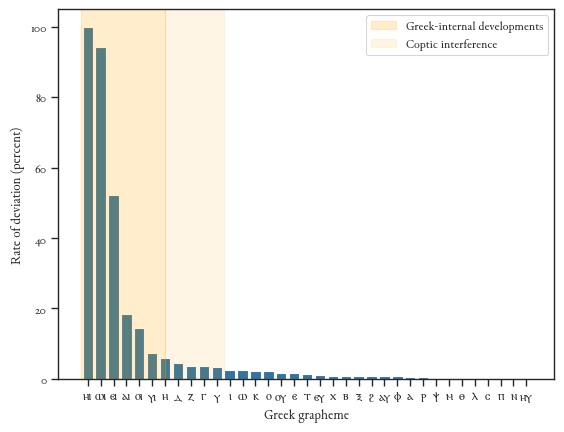

In [69]:
replacements = pd.concat([consonant_regularity.T.sum(), vowel_regularity.T.sum()]).sort_values(ascending=False)
sns.barplot(replacements)
plt.axvspan(xmin=-0.55, xmax=6, color='orange', alpha=0.2, label='Greek-internal developments')
plt.axvspan(xmin=6, xmax=10.53, color='orange', alpha=0.1, label='Coptic interference')
#plt.axvspan(xmin=10.55, xmax=34, color='green', alpha=0.1, label='Occasional variation')
#sns.despine(trim=True)
plt.ylabel("Rate of deviation (percent)")
plt.xlabel("Greek grapheme")
plt.legend()
write_figure("deviation_rate_by_grapheme")

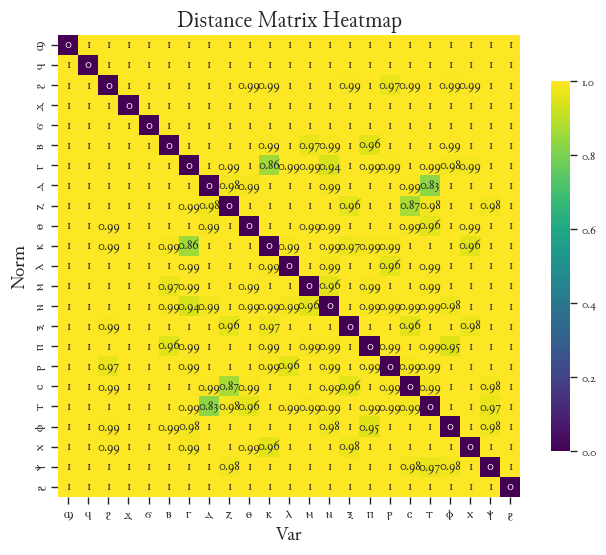

/tmp/nix-shell.VOfIjX/ipykernel_2775623/745626487.py:27: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linked = linkage(distance_matrix, method='average')


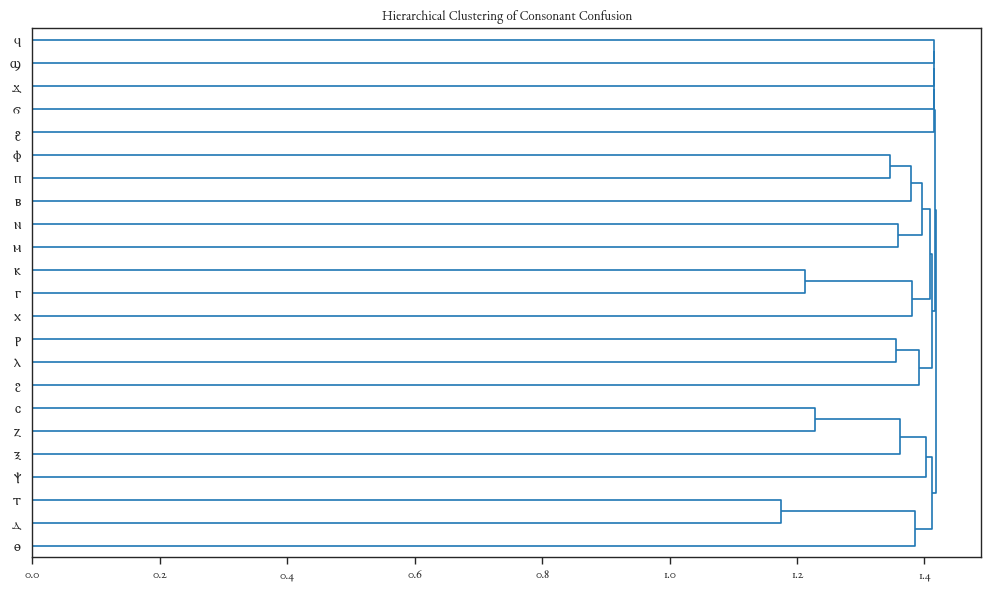

In [70]:
norm_confusion = consonant_frequency.copy().astype(float)

for grapheme in norm_confusion.index:
    if grapheme in consonant_occurrences:
        total = consonant_occurrences[grapheme]
        if total > 0:
            norm_confusion.loc[grapheme] = norm_confusion.loc[grapheme] / total

sym_norm_confusion = (norm_confusion + norm_confusion.T) / 2

distance_matrix = 1 - sym_norm_confusion.values ** 0.5
distance_df = pd.DataFrame(distance_matrix, index=sym_norm_confusion.index, columns=sym_norm_confusion.index)
np.fill_diagonal(distance_matrix, 0)
distance_matrix[np.isnan(distance_matrix)] = 1
distance_df.iloc[:, :] = distance_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(distance_df, annot=True, cmap='viridis', square=True, cbar_kws={"shrink": .8})

plt.title('Distance Matrix Heatmap', fontsize=16)
plt.xlabel('Var', fontsize=14)
plt.ylabel('Norm', fontsize=14)
plt.show()

from scipy.cluster.hierarchy import linkage, dendrogram

linked = linkage(distance_matrix, method='average')
plt.figure(figsize=(10, 6))
dendrogram(linked, labels=distance_df.index, orientation='right')
plt.title("Hierarchical Clustering of Consonant Confusion")
plt.tight_layout()
plt.show()

In [71]:
all_consonant_regularities = pd.DataFrame(consonant_regularity.stack()).reset_index().rename(columns={"level_0": "norm", "norm": "var", 0: "regularity"})
all_consonant_frequencies  = pd.DataFrame(consonant_frequency.stack()).reset_index().rename(columns={0: "frequency"})
consonant_deviations = pd.merge(all_consonant_regularities, all_consonant_frequencies, on=["norm", "var"])
write_csv(consonant_deviations, "deviations-consonants")

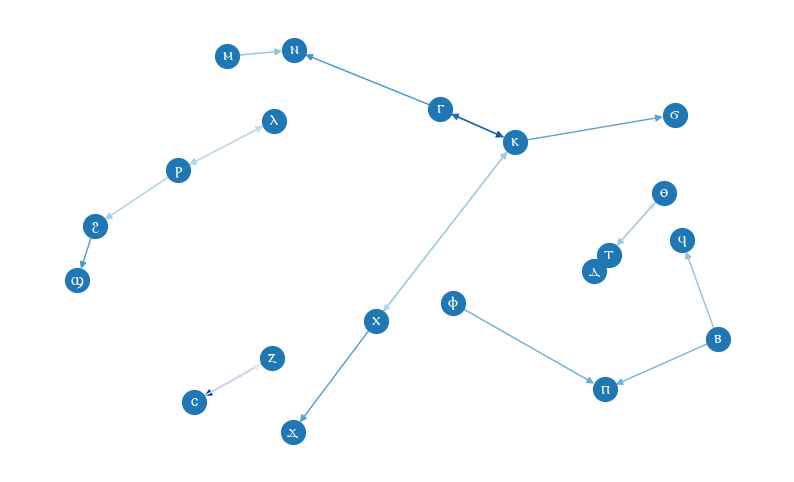

In [72]:
graph = nx.from_pandas_edgelist(
    consonant_deviations[consonant_deviations["frequency"] >= 20],
    source="norm",
    target="var",
    edge_attr=["frequency", "regularity"],
    create_using=nx.DiGraph
)

pos = nx.spring_layout(graph, k=2.2, weight="frequency", seed=342)

fig = plt.figure(figsize=(10, 6))
nx.draw(
    graph,
    pos,
    with_labels=True,
    font_family="Antinoou",
    font_color="white",
    ax = fig.add_subplot(),
    edge_color = [math.log(r) for r in nx.get_edge_attributes(graph, 'regularity').values()],
    edge_cmap = plt.cm.Blues,
)
fig.savefig(subdirectory / "figure-consonants_graph.svg")
plt.show()

In [73]:
stops = df_diff[df_diff["norm"].isin({"ⲃ", "ⲇ", "ⲅ", "ⲡ", "ⲧ", "ⲕ", "ⲫ", "ⲑ", "ⲭ"})].copy()
stops["realization"] = stops["var"].apply(lambda x: "unvoiced plosive" if x in {"ⲡ", "ⲧ", "ⲕ", "ϭ", "ϫ"} else "voiced plosive" if x in {"ⲇ", "ⲅ"} else "nasal" if x in {"ⲙ", "ⲛ"} else "plosive + /h/" if x in {"ⲡϩ", "ⲧϩ", "ⲕϩ"} else "fricative" if x in {"ⲃ", "ϩ", "ϥ", "ⲍ", "ⲥ", "ϣ"} else "∅" if x == "∅" else None)

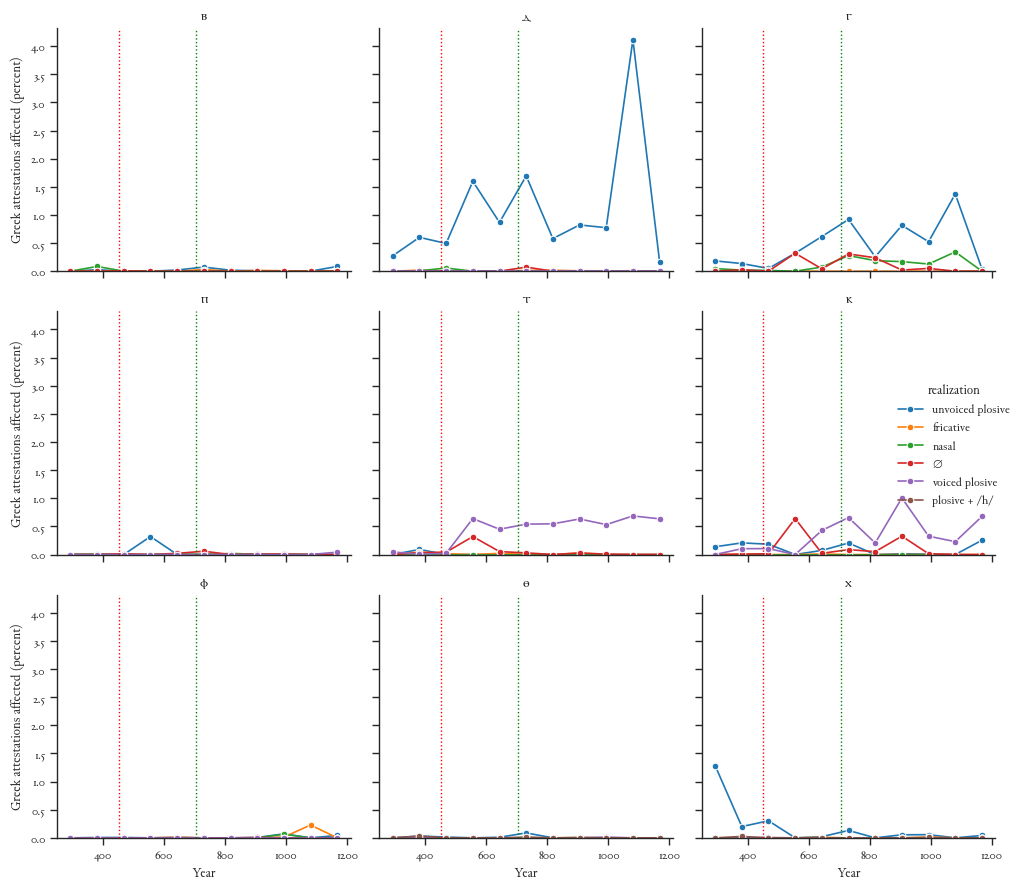

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

full_dates = df_attestations['date_approximate'].dropna()
bins = np.linspace(full_dates.min(), full_dates.max(), 12)
bin_centers = (bins[:-1] + bins[1:]) / 2
full_counts, _ = np.histogram(full_dates, bins=bins)
full_counts_safe = np.where(full_counts == 0, 1e-8, full_counts)

plot_data = []

# Iterate over each combination of norm and realization
for norm_value in stops["norm"].unique():
    norm_subset = stops[stops["norm"] == norm_value]

    for realization_value in norm_subset["realization"].dropna().unique():
        subset = norm_subset[norm_subset["realization"] == realization_value]
        dates = subset['date_approximate'].dropna()

        # Histogram
        counts, _ = np.histogram(dates, bins=bins)
        ratio = counts / full_counts_safe
        
        # Collect results
        for x, y in zip(bin_centers, ratio):
            plot_data.append({
                'year': x,
                'ratio': y * 100,
                'norm': norm_value,
                'realization': realization_value
            })

plot_df = pd.DataFrame(plot_data)

g = sns.FacetGrid(plot_df, col="norm", hue="realization", col_wrap=3, sharey=True, col_order=["ⲃ", "ⲇ", "ⲅ", "ⲡ", "ⲧ", "ⲕ", "ⲫ", "ⲑ", "ⲭ"])
g.map_dataframe(sns.lineplot, marker='o', x="year", y="ratio")
g.set(ylim=0)
g.set_axis_labels("Year", "Greek attestations affected (percent)")
g.set_titles(col_template="{col_name}")

for ax in g.axes.flat:
    ax.axvline(x=451, color='red', linestyle=':', linewidth=1, label="Council of Chalcedon")
    ax.axvline(x=705, color='green', linestyle=':', linewidth=1, label="Arabic administration")

g.add_legend()

plt.tight_layout()
plt.show()
g.savefig(subdirectory / "figure-plosives_by_year.svg")


## What influences plosive deviation?

In [75]:
def categorize(row):
    if row["shift_class"] == 'aspiration' and row["shift_origin"] == "nongreek":
        return "aspiration"
    elif row['shift_class'] == "voiced_voiceless":
        return "voicing"
    else:
        return "other"

xtab_aspiration = pd.crosstab(df_diff.apply(categorize, axis=1), df_diff.dialect_group == "B").rename(
    columns={ True: 'B', False: 'non-B' },
)

stat_aspiration = contingency_statistics(xtab_aspiration)

write_csv(xtab_aspiration, "aspiration")
write_json(stat_aspiration, "aspiration")

print(stat_aspiration)
xtab_aspiration #/ expected

{'chi^2': 96.75440905087544, 'p': 9.773430403353128e-22, 'df': 2, 'V': 0.04669823391448499}


dialect_group,non-B,B
row_0,,
aspiration,185,36
other,38087,2392
voicing,3556,112


In [76]:
xtab_aspiration_deluxe = chi2_deluxe(xtab_aspiration)
write_csv(xtab_aspiration_deluxe, "aspiration_contributions")
xtab_aspiration_deluxe

dialect_group,non-B,B
row_0,,
aspiration,"–, χ² = 2.62 n. s.","+, χ² = 43.09 ***"
other,"–, χ² = 0.15 n. s.","+, χ² = 2.40 n. s."
voicing,"+, χ² = 2.78 n. s.","–, χ² = 45.72 ***"


## What influences lambdacism?

In [77]:
xtab_lambdacism = pd.crosstab(
    df_diff['shift_class'] == "lambdacism",
    df_diff['dialect_group'].isin({"F"})
).rename(
    columns={False: "S/B/M/L/A", True: "F"}
)


stat_lambdacism = contingency_statistics(xtab_lambdacism)

write_csv(xtab_lambdacism, "lambdacism")
write_json(stat_lambdacism, "lambdacism")

print(stat_lambdacism)
xtab_lambdacism

{'chi^2': 2.1544136810185988, 'p': 0.14216070104761824, 'df': 1, 'V': 0.007794396865947737}


dialect_group,S/B/M/L/A,F
shift_class,,
False,42021,2169
True,174,4


In [78]:
chi2_deluxe(xtab_lambdacism)

dialect_group,S/B/M/L/A,F
shift_class,,
False,"–, χ² = 0.00 n. s.","+, χ² = 0.01 n. s."
True,"+, χ² = 0.13 n. s.","–, χ² = 2.55 n. s."


# What influences aspiration?

In [79]:
vowel = ("ⲁ", "ⲉ", "ⲓ", "ⲟ", "ⲩ", "ⲏ", "ⲱ")
vowel_or_spiritus = tuple([*vowel, *map(lambda x: "ϩ" + x, vowel)])

vocalic_initial = df_attestations[df_attestations["greek_lemma"].str.startswith(vowel_or_spiritus) & df_attestations["orthography_clean"].str.startswith(vowel_or_spiritus)]

vocalic_initial = vocalic_initial.assign(
    greek_h=vocalic_initial["greek_lemma"].str.startswith("ϩ"),
    coptic_h=vocalic_initial["orthography_clean"].str.startswith("ϩ")
)
vocalic_initial["century"] = (vocalic_initial["date_approximate"] // 100)

pattern = re.compile(r"ⲁⲩ|ⲁⲓ|ⲉⲓ|ⲟⲩ|ⲟⲓ|ⲉⲩ|[ⲁⲉⲓⲟⲩⲏⲱ]")

def find_first_vowel(text):
    match = pattern.search(text)
    return match.group(0) if match else None

vocalic_initial["initial_vowel"] = vocalic_initial["greek_lemma"].apply(find_first_vowel)

In [80]:
xtab_spiritus = pd.crosstab(vocalic_initial["greek_h"], vocalic_initial["coptic_h"], normalize=True)
write_csv(xtab_spiritus, "spiritus")
xtab_spiritus

coptic_h,False,True
greek_h,,
False,0.818749,0.035869
True,0.013782,0.131599


In [81]:
agreement = (vocalic_initial['greek_h'] == vocalic_initial['coptic_h']).mean()
agreement

0.9503485288747042

In [82]:
pd.DataFrame(vocalic_initial.groupby('dialect_group').apply(
    lambda g: (g['greek_h'] == g['coptic_h']).mean()
).sort_values().rename(index="Agreement proportion"))

/tmp/nix-shell.VOfIjX/ipykernel_2775623/3249530916.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pd.DataFrame(vocalic_initial.groupby('dialect_group').apply(
/tmp/nix-shell.VOfIjX/ipykernel_2775623/3249530916.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pd.DataFrame(vocalic_initial.groupby('dialect_group').apply(


,Agreement proportion
dialect_group,
B,0.873605
M,0.888529
A,0.902703
F,0.935031
L,0.952690
S,0.959311


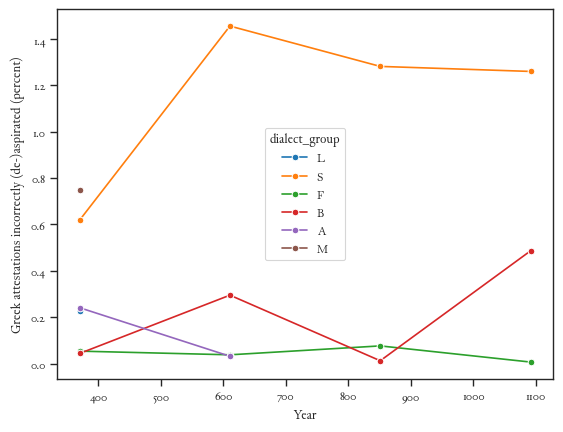

In [83]:
full_dates = df_attestations['date_approximate'].dropna()
bins = np.linspace(full_dates.min(), full_dates.max(), 5)
bin_centers = (bins[:-1] + bins[1:]) / 2
full_counts, _ = np.histogram(full_dates, bins=bins)
full_counts_safe = np.where(full_counts == 0, 1e-8, full_counts)
# TODO this needs to be by dialect
plot_data = []

for dialect_group in vocalic_initial["dialect_group"].unique():
    dialect_subset = vocalic_initial[(vocalic_initial["dialect_group"] == dialect_group) & (vocalic_initial["greek_h"] != vocalic_initial["coptic_h"])]

    dates = dialect_subset['date_approximate'].dropna()

        # Histogram
    counts, _ = np.histogram(dates, bins=bins)
    ratio = counts / full_counts_safe
    
    # Collect results
    for x, y in zip(bin_centers, ratio):
        plot_data.append({
            'year': x,
            'ratio': y * 100,
            'dialect_group': dialect_group,
        })

plot_df = pd.DataFrame(plot_data).replace(0, np.nan)
sns.lineplot(plot_df, x="year", y="ratio", hue="dialect_group", marker='o')
plt.ylabel("Greek attestations incorrectly (de-)aspirated (percent)")
plt.xlabel("Year")
write_figure("aspiration_by_dialect")
plt.show()

In [84]:
vocalic_initial[vocalic_initial['greek_h'] != vocalic_initial['coptic_h']]["greek_lemma"].unique()

array(['ⲉⲗⲡⲓⲍⲱ', 'ⲉⲑⲛⲟⲥ', 'ⲉⲗⲡⲓⲥ', 'ⲉⲓ', 'ϩⲁⲣⲙⲁ', 'ϩⲟⲣⲙⲓⲥⲕⲟⲥ', 'ϩⲱⲥ',
       'ⲁⲙⲏⲛ', 'ϩⲁⲅⲓⲟⲥ', 'ⲉⲓⲕⲱⲛ', 'ⲓⲥⲟⲥ', 'ϩⲟⲣⲁⲥⲓⲥ', 'ϩⲉⲱⲥ', 'ϩⲟⲥⲟⲥ',
       'ϩⲟⲧⲓ', 'ϩⲓⲛⲁ', 'ϩⲁⲗⲩⲥⲓⲥ', 'ⲓⲥⲁⲅⲅⲉⲗⲟⲥ', 'ⲉⲓⲣⲏⲛⲏ', 'ϩⲟⲙⲓⲗⲓⲁ',
       'ⲟⲃⲟⲗⲟⲥ', 'ⲱⲓⲇⲏ', 'ϩⲟⲙⲟⲗⲟⲅⲉⲱ', 'ϩⲟⲗⲟⲥ', 'ϩⲟⲣⲙⲏ', 'ⲁⲗⲁⲕⲁⲧⲁ',
       'ϩⲓⲥⲧⲏⲙⲓ', 'ⲉⲧⲁⲍⲱ', 'ϩⲩⲡⲁⲣⲭⲱ', 'ⲟⲣⲅⲏ', 'ϩⲩⲇⲱⲣ', 'ϩⲟⲙⲟⲩ', 'ϩⲉⲕⲧⲟⲥ',
       'ⲁⲣⲁ', 'ϩⲩⲡⲏⲣⲉⲧⲉⲱ', 'ϩⲟⲧⲁⲛ', 'ϩⲩⲡⲟⲙⲉⲛⲱ', 'ϩⲩⲃⲣⲓⲥ', 'ⲉⲑⲛⲓⲕⲟⲥ',
       'ⲏⲇⲏ', 'ϩⲩⲓⲟⲥ', 'ⲉⲛⲛⲉⲁⲥ', 'ⲉⲓⲗⲓⲕⲣⲓⲛⲏⲥ', 'ⲟⲅⲇⲟⲁⲥ', 'ϩⲉⲝⲁⲥ',
       'ϩⲏⲗⲓⲁⲕⲟⲥ', 'ϩⲩⲡⲉⲣⲁⲥⲁⲗⲉⲩⲧⲟⲥ', 'ⲓⲇⲓⲟⲥ', 'ⲁⲅⲛⲉⲓⲁ', 'ϩⲩⲡⲟⲭⲟⲛⲇⲣⲓⲟⲥ',
       'ϩⲏⲗⲓⲟⲥ', 'ⲟⲗⲓⲅⲟⲥ', 'ϩⲏⲛⲓⲟⲭⲟⲥ', 'ϩⲉⲗⲗⲉⲃⲟⲣⲟⲥ', 'ϩⲉⲣⲙⲏⲛⲉⲩⲱ', 'ⲓⲇⲉⲁ',
       'ⲓⲥⲟⲇⲩⲛⲁⲙⲓⲁ', 'ⲓⲥⲟⲭⲣⲟⲛⲟⲥ', 'ⲉⲓⲕⲟⲛⲓⲕⲟⲥ', 'ϩⲟⲓⲟⲥ', 'ⲟⲓⲕⲟⲛⲟⲙⲓⲁ',
       'ϩⲁⲅⲗⲁⲟⲥ', 'ⲟⲡⲱⲣⲁ', 'ⲓⲥⲟⲇⲩⲛⲁⲙⲟⲥ', 'ϩⲱⲥⲁⲛⲛⲁ', 'ⲓⲇⲓⲱⲧⲏⲥ', 'ⲉⲑⲟⲥ',
       'ⲟⲕⲛⲉⲱ', 'ⲓⲧⲁⲗⲓⲕⲟⲥ', 'ⲁⲣⲙⲁ', 'ϩⲓⲉⲣⲁⲧⲓⲕⲟⲥ', 'ⲏⲧⲣⲟⲛ', 'ϩⲁⲣⲡⲁⲍⲱ',
       'ϩⲟⲡⲗⲟⲛ', 'ⲁⲙⲙⲁⲛⲓⲧⲏⲥ', 'ϩⲏⲥⲩⲭⲁⲍⲱ', 'ϩⲟⲙⲟⲓⲟⲥ', 'ϩⲉⲧⲟⲓⲙⲟⲥ',
       'ϩⲁⲅⲓⲱⲥⲩⲛⲏ', 'ϩⲁⲡⲗⲱⲥ', 'ϩⲉⲃⲇⲟⲙⲁⲥ', 'ⲁⲛⲁⲗⲱⲙⲁ', 'ⲟⲕⲛⲟⲥ', 'ⲉⲑⲱ',
       'ϩⲉⲯⲏⲙⲁ', 'ϩⲁⲗⲱⲛⲓⲁ'

<Axes: xlabel='date_approximate', ylabel='Count'>

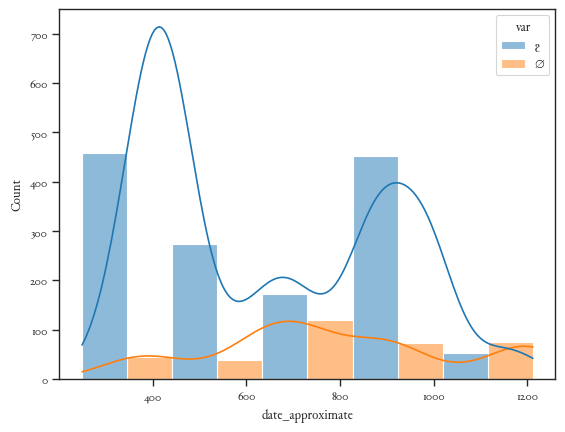

In [85]:
un_aspiration = df_diff[((df_diff["norm"] == "ϩ") & (df_diff["var"] == "∅")) | ((df_diff["norm"] == "∅") & (df_diff["var"] == "ϩ"))].copy()
sns.histplot(data=un_aspiration, x='date_approximate', hue='var', multiple="dodge", bins=5, kde=True)

# Epenthesis

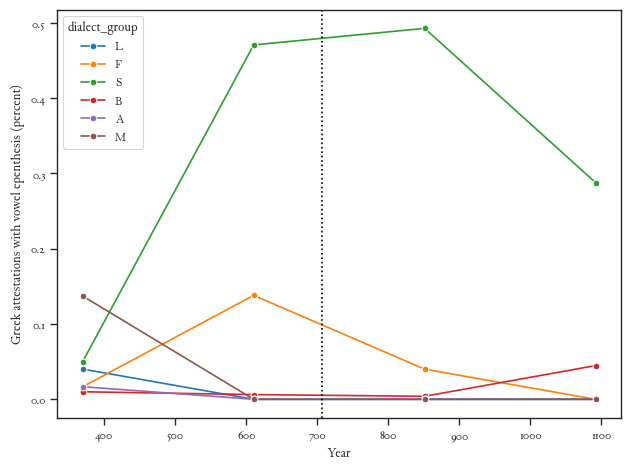

In [86]:
epentheses = df_diff[(df_diff["norm"] == "∅") & df_diff["var"].isin(vowels | diphthongs)].copy()
#epentheses["inserted vowel"] = epentheses["var"].apply(lambda x: "close front vowel" if x in {"ⲓ", "ⲩ", "ⲉⲓ"} else "close-mid front vowel" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "back vowel" if x in {"ⲱ", "ⲟ", "ⲟⲩ"} else "ⲁ /a/" if x in {"ⲁ"} else None)

full_dates = df_attestations['date_approximate'].dropna()
bins = np.linspace(full_dates.min(), full_dates.max(), 5)
bin_centers = (bins[:-1] + bins[1:]) / 2
full_counts, _ = np.histogram(full_dates, bins=bins)
full_counts_safe = np.where(full_counts == 0, 1e-8, full_counts)

plot_data = []

# Iterate over each combination of norm and realization

for realization_value in epentheses["dialect_group"].dropna().unique():
    subset = epentheses[epentheses["dialect_group"] == realization_value]
    dates = subset['date_approximate'].dropna()

    # Histogram
    counts, _ = np.histogram(dates, bins=bins)
    ratio = counts / full_counts_safe
    
    # Collect results
    for x, y in zip(bin_centers, ratio):
        plot_data.append({
            'year': x,
            'ratio': y * 100,
            'dialect_group': realization_value
        })

plot_df = pd.DataFrame(plot_data)

sns.lineplot(plot_df, x="year", y="ratio", hue="dialect_group", marker='o')

plt.xlabel("Year")
plt.ylabel("Greek attestations with vowel epenthesis (percent)")

plt.axvline(706, color="black", linestyle=":")

plt.tight_layout()
write_figure("epenthesis_by_year")
plt.show()


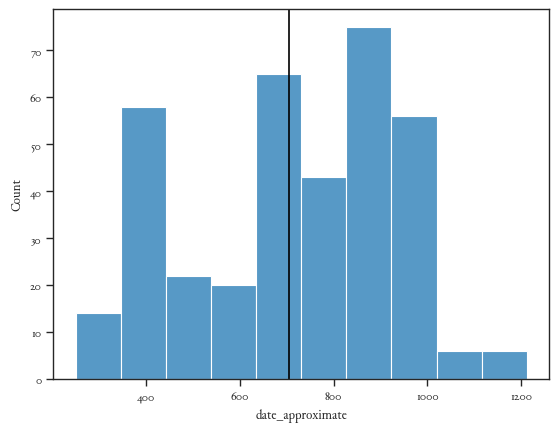

In [87]:
sns.histplot(epentheses, x="date_approximate", kde=False)#(interesting_insertions["var"], interesting_insertions["century"]).style.background_gradient(axis=None, cmap=cm)
plt.axvline(x=705, color="black", label="Arabic becomes official language")
#plt.legend()

In [88]:
xtab_epenthesis = pd.crosstab(df_diff.apply(lambda row: (row["norm"] == "∅") and row["var"] in (vowels), axis=1), df_diff["date_approximate"] > 705).rename(
    columns={True: "Arab era", False: "pre-Arab era"},
    index={True: "vocalic epenthesis", False: "other"}
)
stat_epenthesis = contingency_statistics(xtab_epenthesis)

write_csv(xtab_epenthesis, "epenthesis")
write_json(stat_epenthesis, "epenthesis")

print(stat_epenthesis)
xtab_epenthesis

{'chi^2': 5.7463476898840815, 'p': 0.016522973999969118, 'df': 1, 'V': 0.011579367397484663}


date_approximate,pre-Arab era,Arab era
row_0,,
other,30638,13038
vocalic epenthesis,515,177


In [89]:
xtab_dialect_epenthesis = pd.crosstab(df_diff.apply(lambda row: (row["norm"] == "∅") and row["var"] in (vowels | diphthongs), axis=1), df_diff["dialect_group"]).rename(
    columns={True: "B", False: "non-B"},
    index={True: "vocalic epenthesis", False: "other"}
)

stat_dialect_epenthesis = contingency_statistics(xtab_dialect_epenthesis)

write_csv(xtab_dialect_epenthesis, "dialect_epenthesis")
write_json(stat_dialect_epenthesis, "dialect_epenthesis")

print(stat_dialect_epenthesis)
xtab_dialect_epenthesis

{'chi^2': 149.15935841167706, 'p': 2.015842568785574e-30, 'df': 5, 'V': 0.05798161757991484}


dialect_group,B,F,M,S,L,A
row_0,,,,,,
other,2438,2122,1184,35796,1554,491
vocalic epenthesis,102,51,56,543,25,6


In [90]:
xtab_dialect_epenthesis_deluxe = chi2_deluxe(xtab_dialect_epenthesis)
write_csv(xtab_dialect_epenthesis_deluxe.T, "dialect_epenthesis_contributions")
xtab_dialect_epenthesis_deluxe

dialect_group,B,F,M,S,L,A
row_0,,,,,,
other,"–, χ² = 1.31 n. s.","–, χ² = 0.07 n. s.","–, χ² = 0.96 n. s.","+, χ² = 0.27 n. s.","+, χ² = 0.01 n. s.","+, χ² = 0.02 n. s."
vocalic epenthesis,"+, χ² = 72.93 ***","+, χ² = 4.17 n. s.","+, χ² = 53.19 ***","–, χ² = 15.07 **","–, χ² = 0.29 n. s.","–, χ² = 0.88 n. s."


# Vowel deletion

<Axes: xlabel='date_approximate', ylabel='Count'>

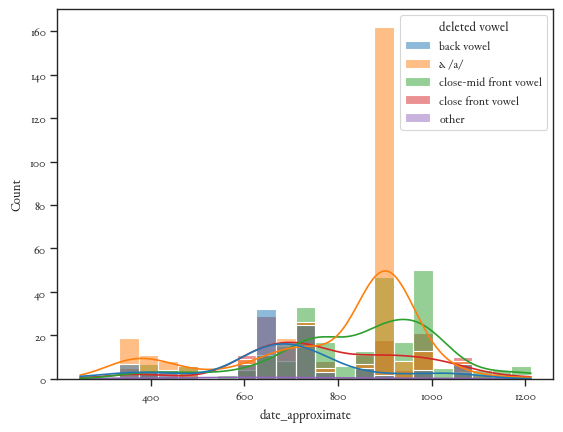

In [91]:
deletions = df_diff[(df_diff["var"] == "∅") & df_diff["norm"].isin(vowels | diphthongs)].copy()
deletions["deleted vowel"] = deletions["norm"].apply(lambda x: "close front vowel" if x in {"ⲓ", "ⲩ", "ⲉⲓ"} else "close-mid front vowel" if x in {"ⲉ", "ⲏ", "ⲁⲓ"} else "back vowel" if x in {"ⲱ", "ⲟ", "ⲟⲩ"} else "ⲁ /a/" if x in {"ⲁ"} else "other")
sns.histplot(deletions, hue="deleted vowel", x="date_approximate", kde=True)

# Older words — older pronunciations

In [92]:
# Group by both 'greek_lemma' and 'dialect_group' to get the minimum date
date_per_lemma = df_diff.groupby(["greek_lemma", "dialect_group"])["date_approximate"].min()

# Count deviations per lemma and dialect group
deviations_per_lemma = df_diff.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()

# Count attestations per lemma and dialect group
attestations_per_lemma = df_attestations.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()

# Create a DataFrame with the results
per_lemma = pd.DataFrame({
    "earliest_attestation": date_per_lemma,
    "deviations": deviations_per_lemma,
    "attestations": attestations_per_lemma
}).dropna()

# Calculate the deviation rate
per_lemma["deviation_rate"] = per_lemma["deviations"].div(per_lemma["attestations"])

# Reset index to make 'greek_lemma' and 'dialect_group' columns
per_lemma = per_lemma.reset_index()
per_lemma

/tmp/nix-shell.VOfIjX/ipykernel_2775623/682983015.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  date_per_lemma = df_diff.groupby(["greek_lemma", "dialect_group"])["date_approximate"].min()
/tmp/nix-shell.VOfIjX/ipykernel_2775623/682983015.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  deviations_per_lemma = df_diff.groupby(["greek_lemma", "dialect_group"])["greek_lemma"].count()
/tmp/nix-shell.VOfIjX/ipykernel_2775623/682983015.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

,greek_lemma,dialect_group,earliest_attestation,deviations,attestations,deviation_rate
0,ϩⲁⲅⲁⲣⲓⲛⲛⲁⲓⲟⲥ,B,1212.0,2.0,1,2.000000
1,ϩⲁⲅⲓⲁⲍⲱ,S,949.5,3.0,18,0.166667
2,ϩⲁⲅⲓⲟⲥ,B,699.5,181.0,178,1.016854
3,ϩⲁⲅⲓⲟⲥ,S,559.5,81.0,943,0.085896
4,ϩⲁⲅⲓⲟⲧⲏⲥ,S,699.5,2.0,1,2.000000
...,...,...,...,...,...,...
3204,ⲱⲫⲉⲗⲉⲓⲁ,F,799.5,4.0,2,2.000000
3205,ⲱⲫⲉⲗⲉⲓⲁ,S,999.5,26.0,16,1.625000
3206,ⲱⲫⲉⲗⲉⲱ,S,699.5,31.0,65,0.476923
3207,ⲱⲫⲉⲗⲉⲱ,A,349.5,1.0,2,0.500000


SignificanceResult(statistic=0.06401504761287267, pvalue=0.0002849227093232645)

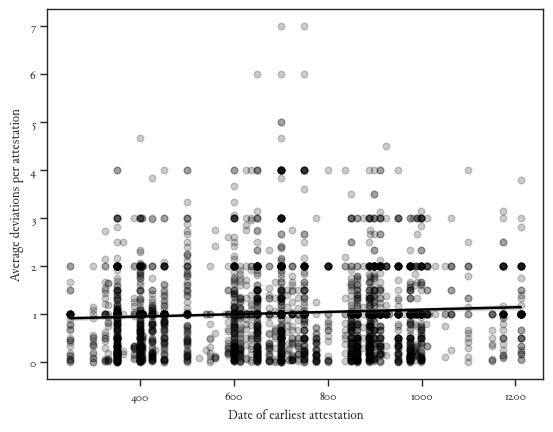

In [93]:
sns.regplot(x="earliest_attestation", y="deviation_rate", data=per_lemma, scatter_kws={'alpha':0.2}, color="black")
plt.ylabel("Average deviations per attestation")
plt.xlabel("Date of earliest attestation")
write_figure("deviation_rate_by_earliest_attestation")
scipy.stats.spearmanr(per_lemma["earliest_attestation"], per_lemma["deviation_rate"])

***

# Misc

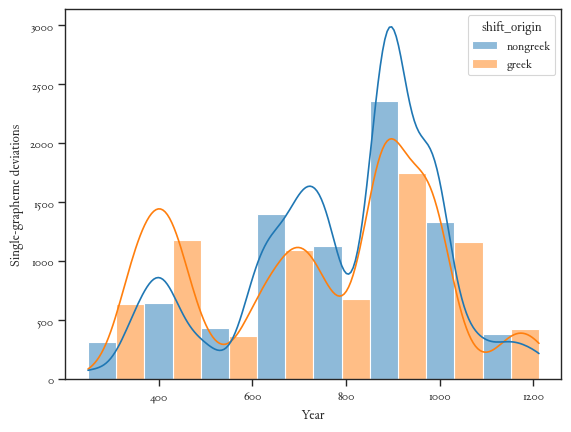

In [94]:
sns.histplot(df_diff, x="date_approximate", hue="shift_origin", multiple="dodge", kde=True, bins=8)
plt.xlabel("Year")
plt.ylabel("Single-grapheme deviations")
write_figure("greek_non_greek")

<Axes: xlabel='date_approximate', ylabel='Count'>

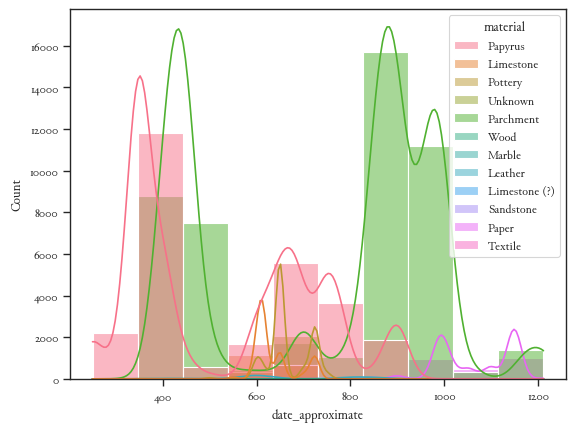

In [95]:
sns.histplot(df_attestations, x="date_approximate", hue="material", bins=10, kde=True)

## Spelling of common words is more consistent

/tmp/nix-shell.VOfIjX/ipykernel_2775623/707813195.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  frequency_df = pd.DataFrame({"attestations": df_attestations["greek_lemma"].value_counts(), "deviations": df_attestations["greek_lemma"].value_counts(), "unique_variants": df_attestations.groupby("greek_lemma")["orthography_clean"].nunique(), "entropy": df_attestations.groupby("greek_lemma").apply(lambda g: scipy.stats.entropy(g["orthography_clean"].value_counts(normalize=True)))


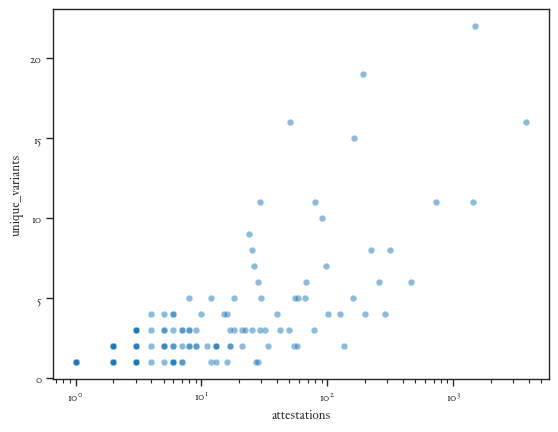

In [96]:
frequency_df = pd.DataFrame({"attestations": df_attestations["greek_lemma"].value_counts(), "deviations": df_attestations["greek_lemma"].value_counts(), "unique_variants": df_attestations.groupby("greek_lemma")["orthography_clean"].nunique(), "entropy": df_attestations.groupby("greek_lemma").apply(lambda g: scipy.stats.entropy(g["orthography_clean"].value_counts(normalize=True)))
}).dropna().sample(200)
#scipy.stats.spearmanr()

sns.scatterplot(frequency_df, y="unique_variants", x="attestations", alpha=0.5)
plt.xscale("log")


## Vowel confusion is more likely at right word edge?

<Axes: >

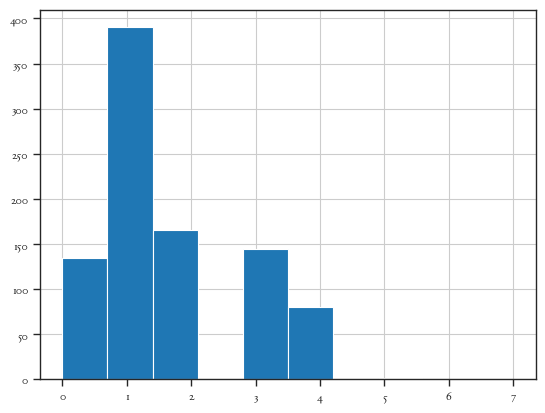

In [97]:
df_diff[df_diff["norm"].isin({"ⲁ", "ⲟ", "ⲉ"}) & df_diff["var"].isin({"ⲁ", "ⲟ", "ⲉ"})]["context_right"].str.count(r"[ⲁⲉⲓⲟⲩⲱⲏ]").hist()

<Axes: >

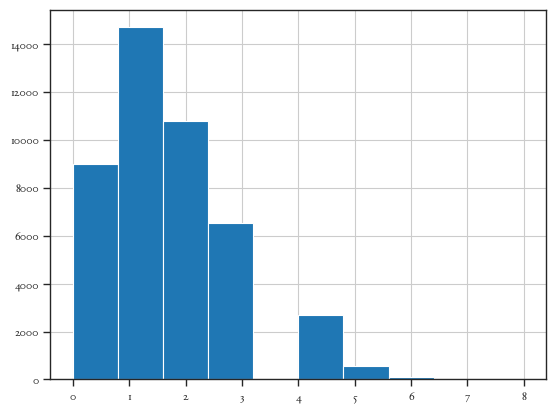

In [98]:
df_diff["context_right"].str.count(r"[ⲁⲉⲓⲟⲩⲱⲏ]").hist()

In [99]:
df_diff[df_diff["norm"].isin(vowels) & (df_diff["var"] == 2 * df_diff["norm"])].sample(10)

,id,norm,var,context_left,context_right,greek_lemma,greek_lemma_original,orthography,orthography_clean,dialect,dialect_group,manuscript_text,date_approximate,earliest,latest,century,shift_class,shift_origin
33449,107054,ⲁ,ⲁⲁ,ⲧⲉⲧⲣ,ⲣⲭⲏⲥ,ⲧⲉⲧⲣⲁⲣⲭⲏⲥ,τετράρχης,ⲧⲉⲧⲣⲁⲁⲣⲭⲏⲥ,ⲧⲉⲧⲣⲁⲁⲣⲭⲏⲥ,S,S,INTF Acta* (sahidic) - Acts of the Apostles,NaN,NaN,NaN,NaN,gemination,greek
798,81611,ⲁ,ⲁⲁ,#,ⲏⲣ,ⲁⲏⲣ,ἀήρ,[ⲁ]|ⲁⲏⲣ,ⲁⲁⲏⲣ,S,S,Berlin - Ägyptisches Museum P. 20915 - Berline...,349.5,300.0,399.0,4.0,gemination,greek
41545,92245,ⲉ,ⲉⲉ,ⲑ,ⲓⲕⲟⲥ,ⲑⲉⲓⲕⲟⲥ,θεϊκός,ⲑⲉⲉⲓⲕⲱⲛ,ⲑⲉⲉⲓⲕⲱⲛ,S,S,Cairo - Egyptian Museum CG 8738 Ro - P.KRU 98 ...,NaN,NaN,NaN,NaN,gemination,greek
24701,199092,ⲁ,ⲁⲁ,ⲥⲁⲣ,ⲃⲉⲑⲑⲉⲓ,ⲥⲁⲣⲁⲃⲉⲑⲑⲉⲓ,Σαραβεθθεί,ⲥⲁⲣⲁⲁⲃⲓⲧⲏⲥ,ⲥⲁⲣⲁⲁⲃⲓⲧⲏⲥ,S,S,New York - The Morgan Library and Museum M.567...,NaN,NaN,NaN,NaN,gemination,greek
33474,107223,ⲁ,ⲁⲁ,#,ⲡⲟⲗⲟⲅⲓⲁ,ⲁⲡⲟⲗⲟⲅⲓⲁ,ἀπολογία,ⲁⲁⲡⲟⲗⲟⲅⲓⲁ,ⲁⲁⲡⲟⲗⲟⲅⲓⲁ,S,S,INTF Acta* (sahidic) - Acts of the Apostles,NaN,NaN,NaN,NaN,gemination,greek
42690,198529,ⲟ,ⲟⲟ,ⲡⲣⲟⲓⲕⲱⲓ,ⲥ#,ⲡⲣⲟⲓⲕⲱⲓⲟⲥ,προικῷος,ⲡⲣⲟⲓⲕⲟⲟ⸌ⲛ̣⸍,ⲡⲣⲟⲓⲕⲟⲟⲛ,S,S,London - British Library Pap 1728 Ro + Pap 174...,NaN,NaN,NaN,NaN,gemination,greek
38826,192994,ⲏ,ⲏⲏ,ⲉⲓⲙ,ⲧⲓ,ⲉⲓⲙⲏⲧⲓ,εἰ μή τι,ⲉⲓⲙⲏⲏⲧⲉⲓ,ⲉⲓⲙⲏⲏⲧⲉⲓ,S,S,Naples - Biblioteca Nazionale IB. 19.01-97 - T...,NaN,NaN,NaN,NaN,gemination,greek
4235,149824,ⲟ,ⲟⲟ,ⲧⲣ,ⲫⲏ#,ⲧⲣⲟⲫⲏ,τροφή,ⲧⲣⲩⲫⲟⲟⲩⲉ,ⲧⲣⲩⲫⲟⲟⲩⲉ,S,S,London - British Library Add MS 5114 - Pistis ...,NaN,NaN,NaN,NaN,gemination,greek
206,8058,ⲁ,ⲁⲁ,#,ⲅⲁⲡⲏ,ⲁⲅⲁⲡⲏ,ἀγάπη,ⲁⲁⲅⲁⲡ[ⲏ],ⲁⲁⲅⲁⲡⲏ,F,F,London - British Library Or 4919(5) - Song of ...,NaN,NaN,NaN,NaN,gemination,greek
6419,93882,ⲁ,ⲁⲁ,#,ⲫⲟⲣⲙⲏ,ⲁⲫⲟⲣⲙⲏ,ἀφορμή,ⲁ[ⲁ]ⲫⲟⲣⲙⲏ,ⲁⲁⲫⲟⲣⲙⲏ,L6,L,"Nag Hammadi Codex I - Tripartite Tractate, The",NaN,350.0,NaN,NaN,gemination,greek
